## Import

In [ ]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit_aer.primitives import Sampler
from qiskit.result import QuasiDistribution
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Sampler
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit

import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Noisy simulation imports
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error
from qiskit_ibm_runtime.fake_provider import FakeVigoV2, FakeTorino, FakeAlmadenV2, FakeManilaV2, FakeJakartaV2, FakeGuadalupeV2
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2



## Generation of data for fictitious assets

For the generation of a number of fictitious assets (`assets`), we used the `RandomDataProvider` class, using the generation seed (`seed`) 1659, for an analysis period from January 1, 2016 (`start_date`) to January 1, 2020 (`end_date`).

The generated data are grouped under tickers, uniquely identified by the string `TICKER_{i}`, where `i` is an integer ranging from 0 to number of `assets - 1`.

In [ ]:
assets = 8
n_repeats = 50
seed = 1659

start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2020, 1, 1)

# Generate the data
tickers = [f"TICKER_{i}" for i in range(assets)]
data_provider = RandomDataProvider(
    tickers=tickers,
    start=start_date,
    end=end_date,
    seed=seed,
)

data_provider.run()
stock_data = data_provider._data

dates = pd.date_range(start=start_date, end=end_date, inclusive="left")

## Print results

In [3]:
def print_result(result, portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Print generated data

In [ ]:
# Function to print the table
def print_table(stock_data, tickers, dates):
    print(f"\n{'Generated Data for the period from':<12} {dates[0].date()} to {dates[-1].date()}:")
    print("-" * 80)
    print(f"{'Date':<12}", end="")
    for ticker in tickers:
        print(f"{ticker:<12}", end="")
    print()
    print("-" * 80)

    for i, date in enumerate(dates):
        print(f"{date.strftime('%Y-%m-%d'):<12}", end="")
        for j in range(len(stock_data)):
            print(f"{stock_data[j][i]:<12.4f}", end="")
        print()
    print("-" * 80)

print_table(stock_data, tickers, dates)


Dati Generati per il periodo dal 2016-01-01 al 2019-12-31:
--------------------------------------------------------------------------------
Data        TICKER_0    TICKER_1    TICKER_2    TICKER_3    TICKER_4    TICKER_5    TICKER_6    TICKER_7    
--------------------------------------------------------------------------------
2016-01-01  80.0573     38.8648     69.2682     76.1653     84.1552     30.5934     17.0995     70.1983     
2016-01-02  80.3390     38.7966     69.5354     76.6583     82.3898     30.6171     18.6950     71.7108     
2016-01-03  79.4722     39.0100     70.7954     76.0500     83.2349     30.5247     19.3007     71.5732     
2016-01-04  79.9877     37.6225     71.0483     75.9067     84.1883     31.4947     19.5102     71.1321     
2016-01-05  80.4394     37.4848     70.0175     75.9257     84.3377     32.3577     18.4481     70.4312     
2016-01-06  78.5876     36.7271     69.1049     76.1394     83.5878     33.2828     18.5898     70.4564     
2016-01-07  78.

## Asset price trends

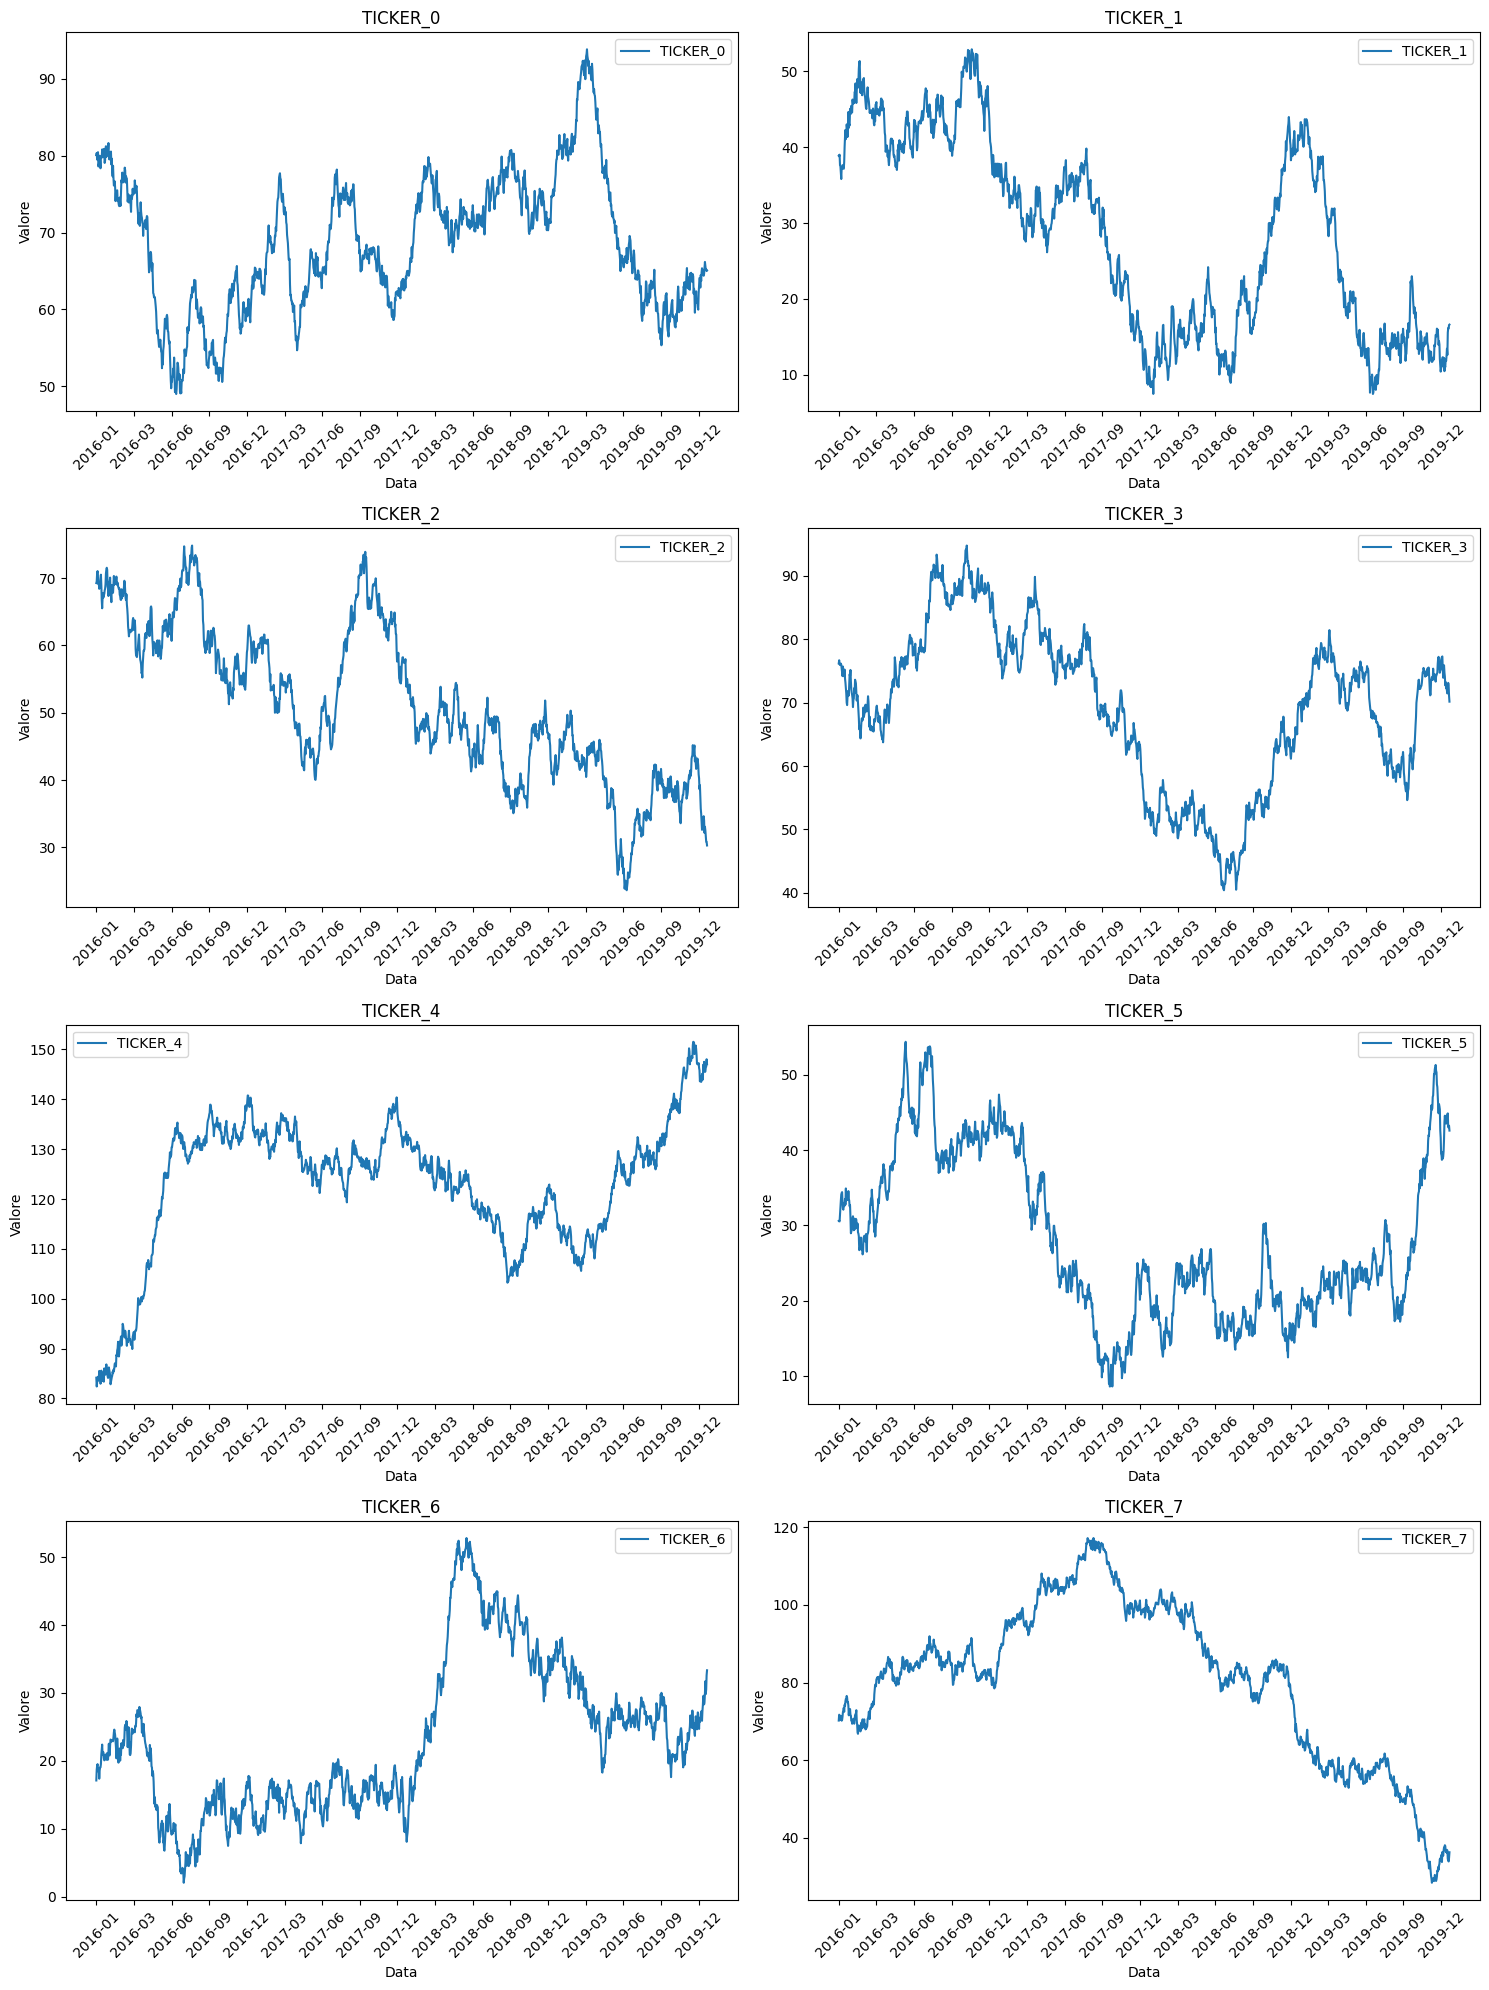

In [ ]:
# Function to create the plots
def create_ticker_plots(stock_data, tickers, dates):
    num_tickers = len(tickers)
    cols = 2  # Number of columns in the grid
    rows = (num_tickers + cols - 1) // cols  # Calculate the number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = np.atleast_1d(axes).flatten()  # Ensure it's a flat array

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        ax.plot(dates, stock_data[i], label=ticker)
        ax.set_title(ticker)
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")

        # Show only months on the x-axis
        ax.set_xticks(dates[::90])  # Every 90 days (approximately one quarter)
        ax.set_xticklabels([date.strftime('%Y-%m') for date in dates[::90]], rotation=45)
        ax.legend()

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

create_ticker_plots(stock_data, tickers, dates)

## Asset covariance matrix

In the following cell, we extract the mean vector of periodic returns and the covariance matrix of periodic returns, which will be used in subsequent steps.

Additionally, we visualize the extracted matrix to graphically observe the correlations between assets.

For visualization, we use the Seaborn library, which provides advanced visualization functionalities, allowing us to create a heatmap with a "coolwarm" color map and a legend to display the range of variation.

> Since we are working with a very large dataset, we obtained a covariance matrix with very small values in the cells. For this reason, we multiplied the values contained in the cells by $10^4$ to better visualize them.

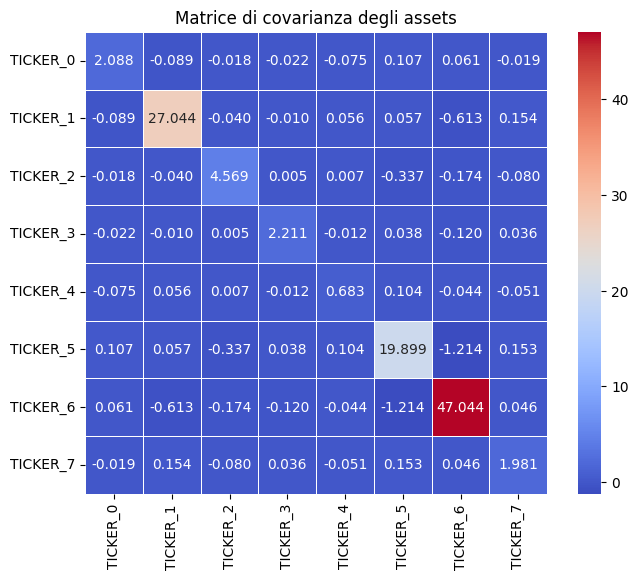

In [ ]:
mu = data_provider.get_period_return_mean_vector()
sigma = data_provider.get_period_return_covariance_matrix()

sigma *= 10000

sigma_df = pd.DataFrame(sigma, index=tickers, columns=tickers)

plt.figure(figsize=(8, 6))
sns.heatmap(
    sigma_df, 
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5,
    square=True
)
plt.title("Asset Covariance Matrix")
plt.show()

sigma /= 10000 

## Problem configuration

For the problem configuration, we chose a low risk factor (`risk_factor`) and a budget proportional to $\dfrac{2}{3}$ of the number of assets.
> We introduced a penalty equal to the budget to penalize solutions that do not meet the problem constraint.

In [7]:
risk_factor = 0.2

budget = int(assets / 3 * 2)
penalty = budget 

print(f"Assets: {assets}, Budget: {budget}, Penalty: {penalty}, Risk: {risk_factor}, Num Repeats: {n_repeats}")

po = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget
)
qp = po.to_quadratic_program()

Assets: 8, Budget: 5, Penalty: 5, Risk: 0.2, Num Repeats: 50


## Algorithm configuration

The algorithms used require a series of configurations related to the optimizer used, backend, and noise_model.
To ensure consistency, we dedicated a cell to the listed configurations.

Among these configurations, we find the one dedicated to the backend, used to simulate a computation affected by noise.
To do this, we used `GenericBackendV2` provided by `qiskit.providers`, specifying during construction the number of qubits, the presence of noise-related information, the generation seed (for reproducibility), and the ability to calibrate instructions.
To complete the backend, we "customized" the noise to which the created backend is subject, using `NoiseModel` specifying a series of errors related to:
- Depolarization and thermal relaxation;
- Specific gates;
- Qubit readout.

In [ ]:

# Common variables for VQE and QAOA
algorithm_globals.random_seed = seed
cobyla = COBYLA()
iter = 250
cobyla.set_options(maxiter=iter)

# doc: https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.GenericBackendV2
backend = GenericBackendV2(num_qubits=assets, 
                           noise_info=True,
                           seed=seed,
                           calibrate_instructions=True)

# Create a custom noise model
# noise_model = NoiseModel.from_backend(backend)
noise_model = NoiseModel()

# Define depolarization and thermal relaxation errors
depol_error_1q = depolarizing_error(0.01, 1)  # Depolarization error for 1-qubit gates
depol_error_2q = depolarizing_error(0.02, 2)  # Depolarization error for 2-qubit gates
thermal_relaxation_error_1q = thermal_relaxation_error(50, 70, 0.1)  # Thermal relaxation error for 1-qubit gates

thermal_relaxation_error_2q = thermal_relaxation_error_1q.tensor(thermal_relaxation_error_1q)
thermal_relaxation_error_3q = thermal_relaxation_error_1q.tensor(thermal_relaxation_error_1q).tensor(thermal_relaxation_error_1q)

# Add errors to specific gates
noise_model.add_all_qubit_quantum_error(depol_error_1q, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depol_error_2q, ['cx'])
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error_1q, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error_2q, ['cx'])
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error_3q, ['ccx'])

# Define a readout error
readout_error = ReadoutError([[0.9, 0.1], [0.1, 0.9]])
noise_model.add_all_qubit_readout_error(readout_error)

# noise_model = NoiseModel.from_backend(backend)
# simulator = AerSimulator(noise_model=noise_model)
simulator = AerSimulator.from_backend(backend)
simulator.set_options(noise_model=noise_model)

print(backend.description)
print(noise_model)

This is a device with 8 qubits and generic settings.
NoiseModel:
  Basis gates: ['ccx', 'cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'cx', 'u2', 'measure', 'ccx']
  All-qubits errors: ['u1', 'u2', 'u3', 'cx', 'ccx', 'measure']


### Classical algorithm
For the classical computation configuration, we used an approach based on a NumPy-based eigenvalue solver and an optimization method.

In [ ]:
# Classical
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result_exact = exact_eigensolver.solve(qp)

print_result(result_exact, po)

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0034

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 1 1 1 1 0]	-0.0034		1.0000


### VQE without noise (noiseless)

The first algorithm analyzed is VQE under noiseless conditions. This algorithm was created using `TwoLocal` to obtain a two-level circuit, specifying the number of qubits equal to the number of assets, rotation blocks along the $y$ axis, entanglement blocks ($cz$), the entanglement type (`full`), and the number of repetitions (1). For circuit visualization, it was necessary to decompose (`.decompose()`) the circuit into smaller blocks.

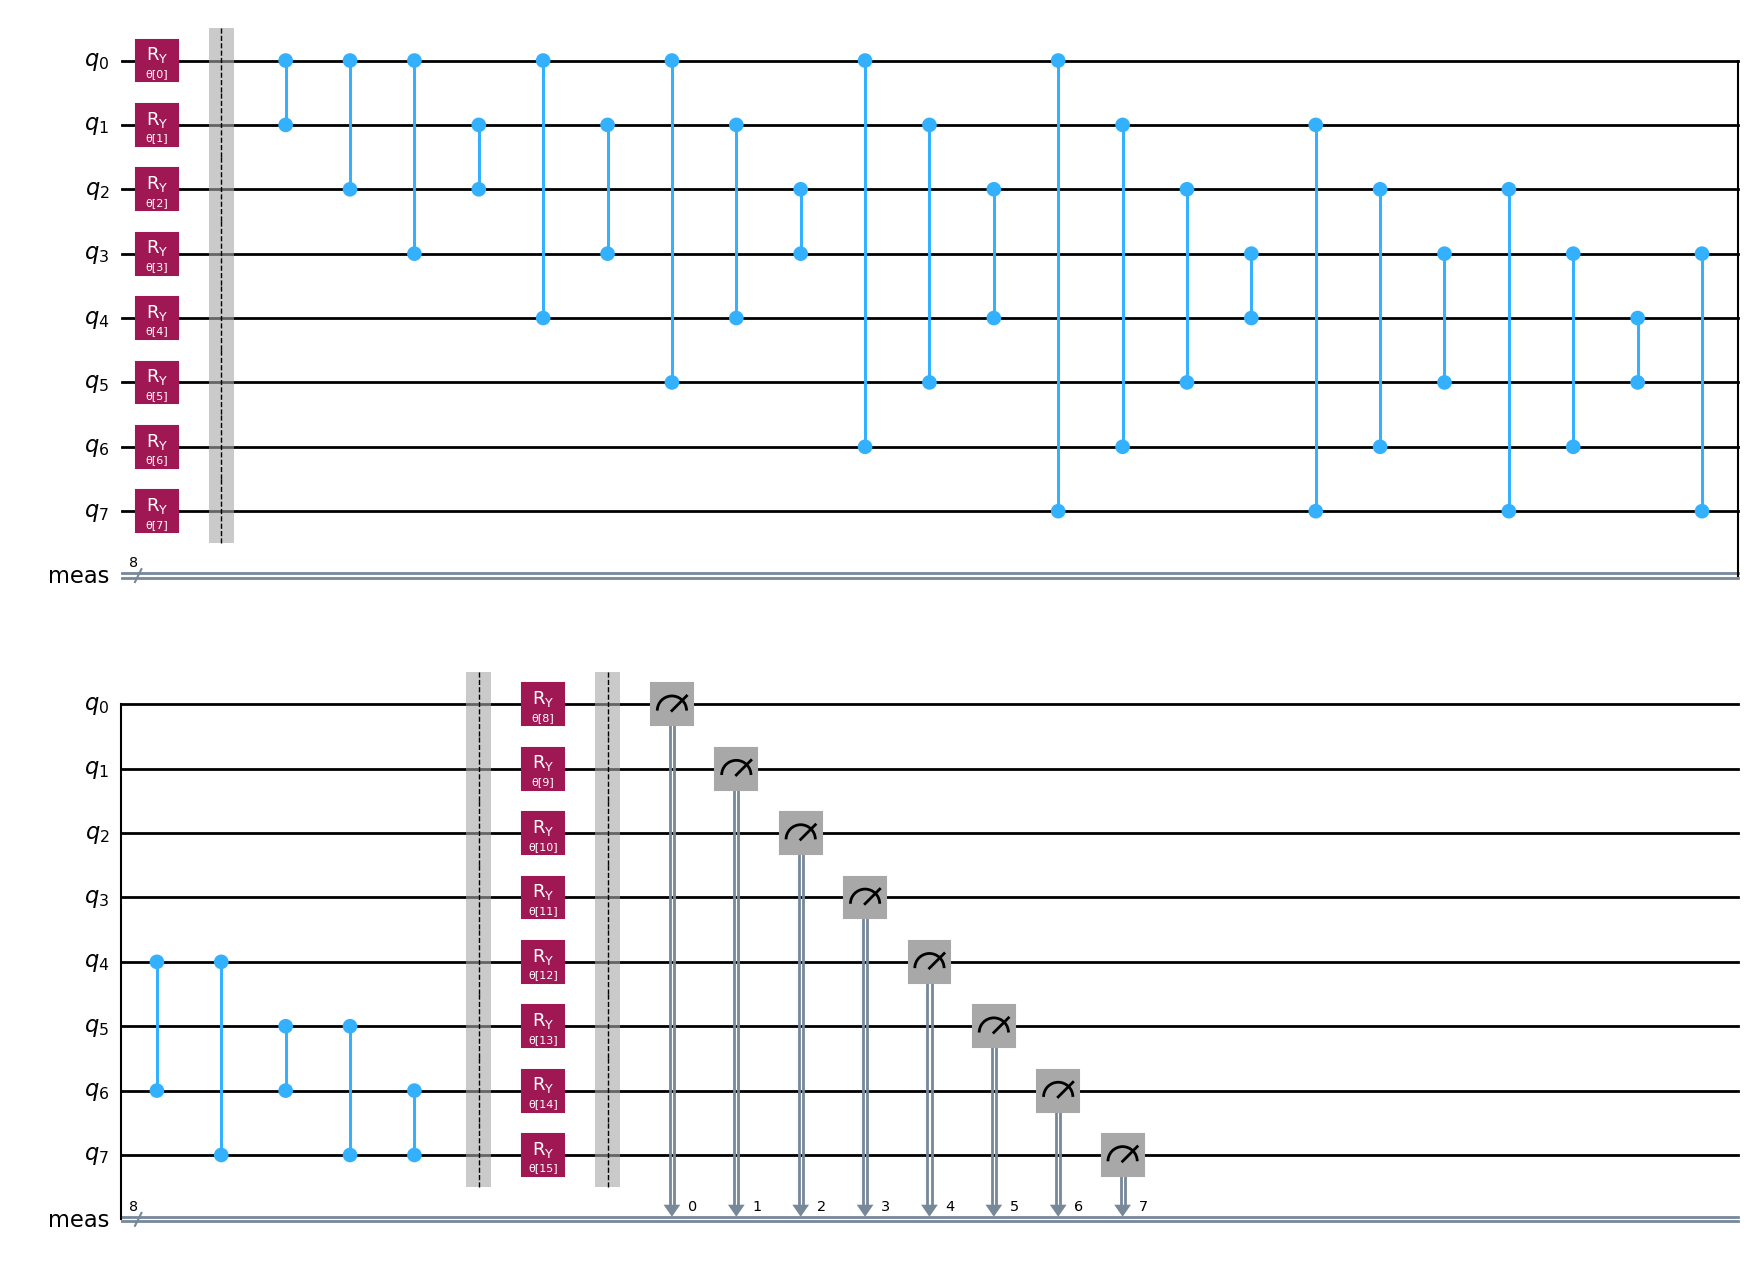

In [10]:
# VQE
ry = TwoLocal(
    num_qubits=assets,
    rotation_blocks="ry",
    entanglement_blocks="cz",
    reps=1,
    entanglement="full",
    insert_barriers=True
)
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes, penalty)
result_svqe = svqe.solve(qp)

# print_result(result_svqe, po)

ry_decomposed = ry.decompose()
ry_decomposed.draw("mpl")

### VQE with noise (noisy)

The second algorithm analyzed is VQE in the noisy version. For this algorithm, we maintained the same circuit structure used in the noiseless version, but the circuit was adapted to the noisy simulator introduced previously using the `transpile` function. This adaptation allowed for execution affected by noise, thus simulating realistic conditions of a noisy quantum environment.

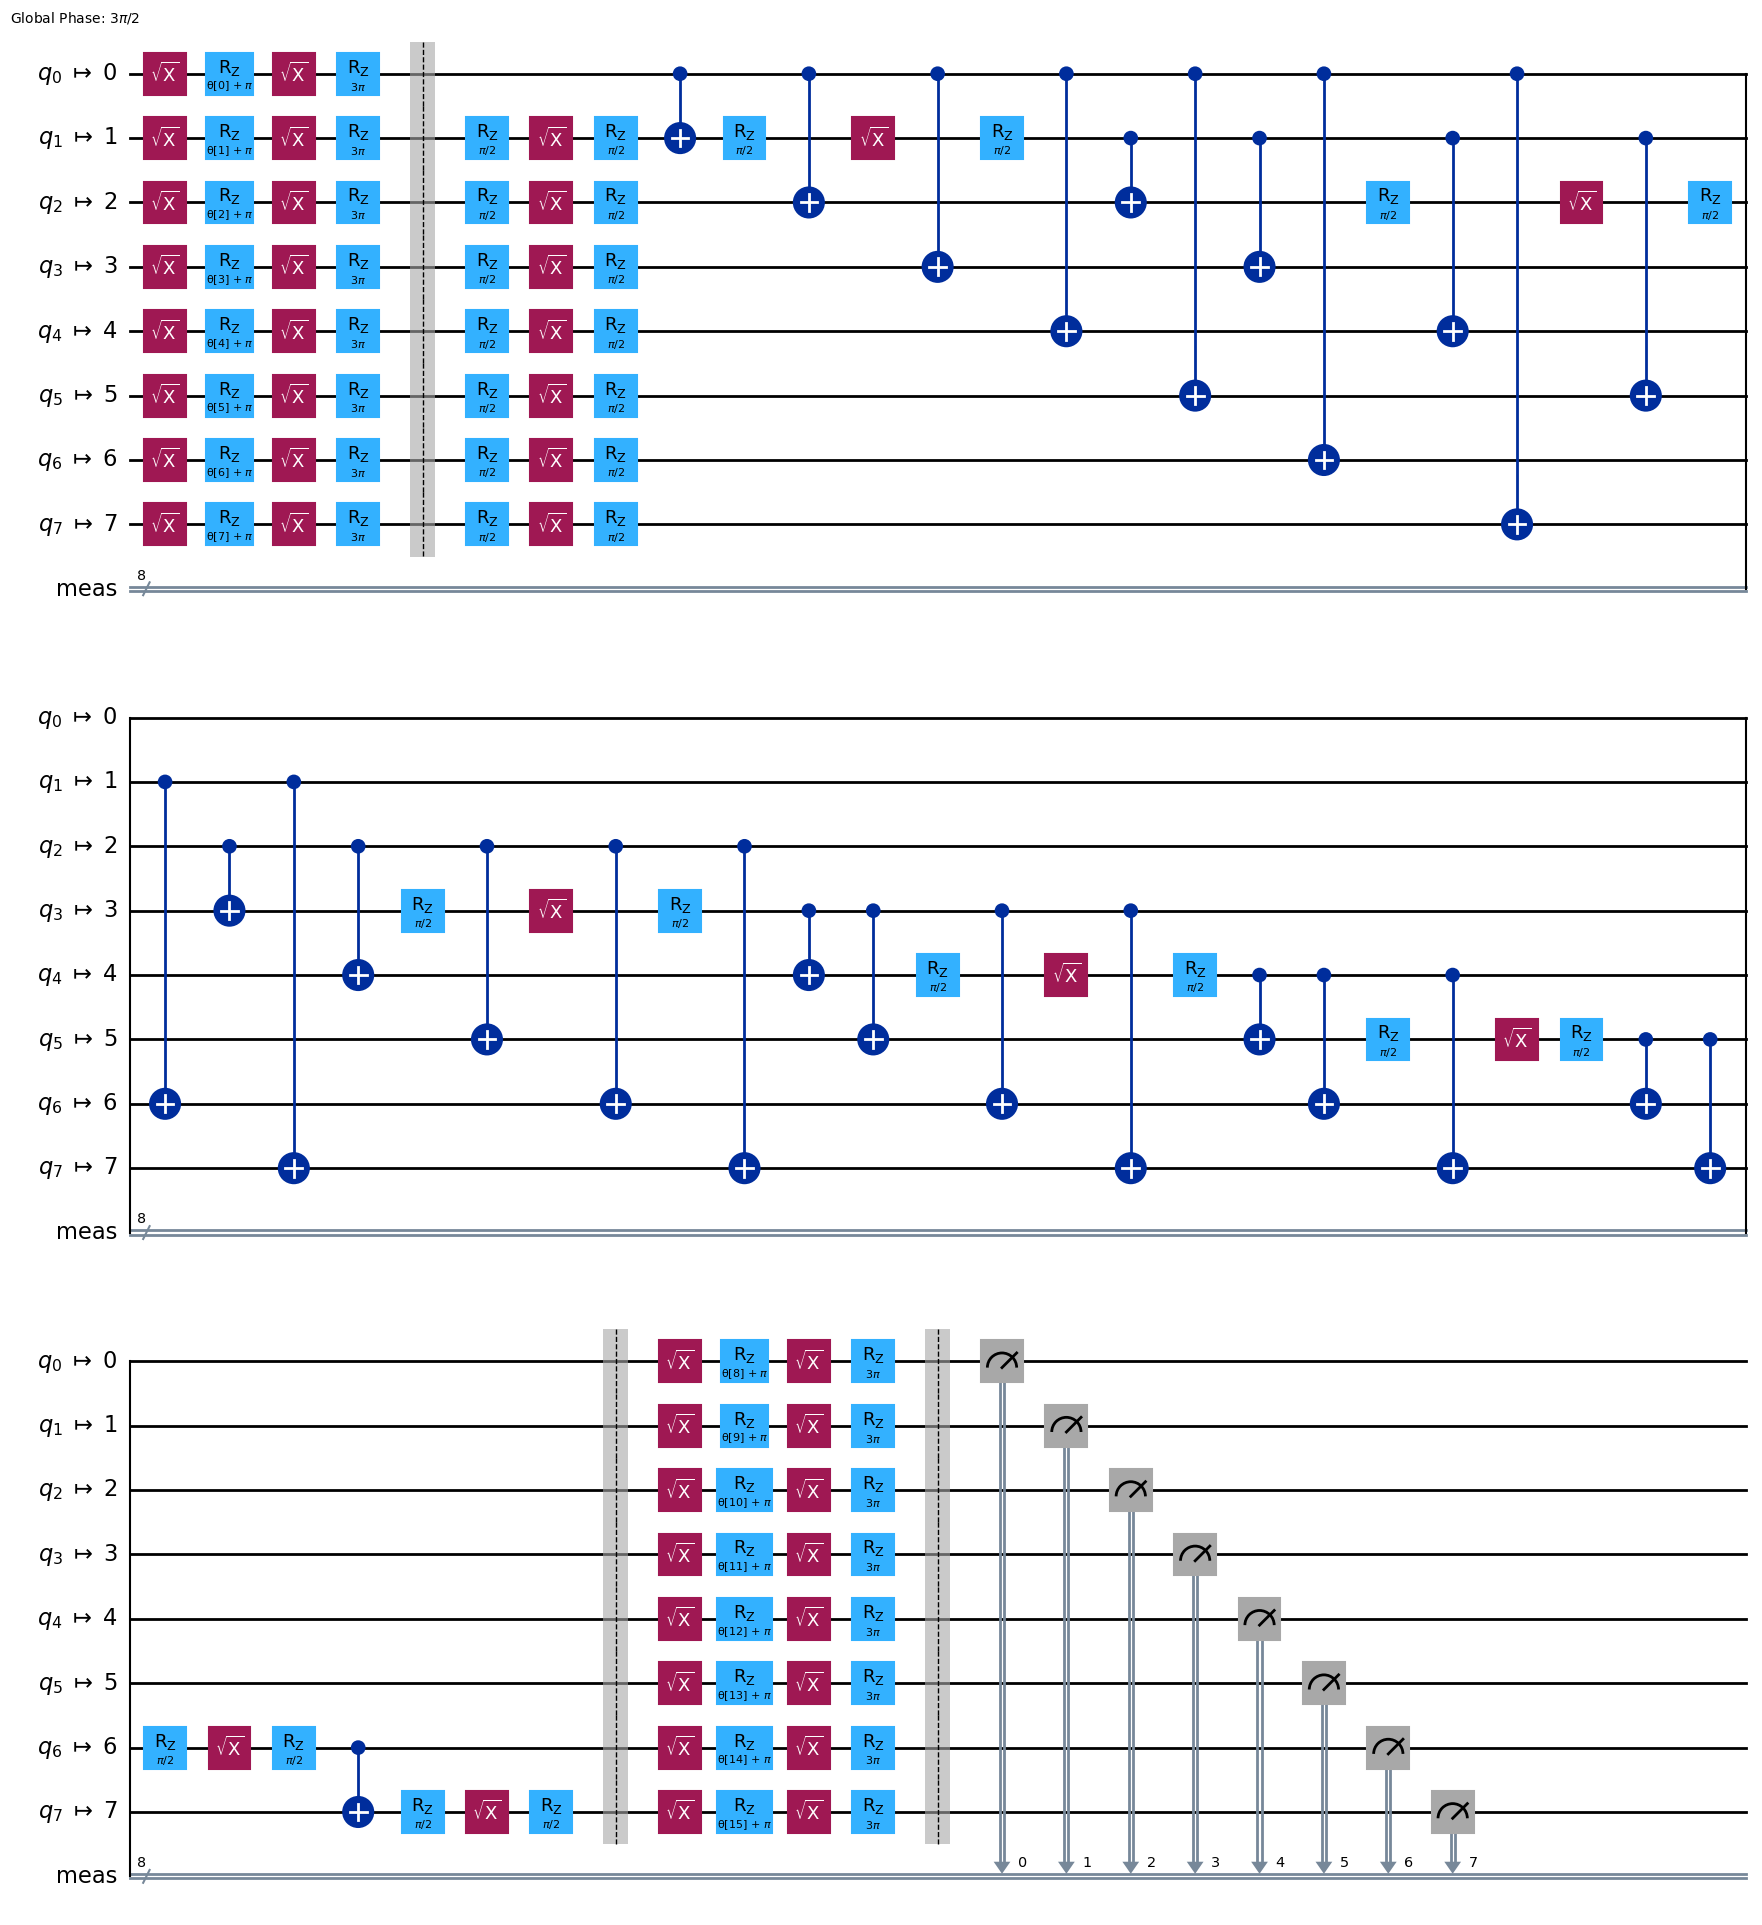

In [11]:
ansatz = TwoLocal(
    num_qubits=assets,
    rotation_blocks="ry",
    entanglement_blocks="cz",
    reps=1,
    entanglement="full",
    insert_barriers=True
)

decomposed_ansatz = ansatz.decompose()
# decomposed_ansatz.draw("mpl")
transpiled_ansatz = transpile(decomposed_ansatz, backend=simulator)

svqe_mes_noisy = SamplingVQE(sampler=Sampler(), ansatz=transpiled_ansatz, optimizer=cobyla)

svqe_noisy = MinimumEigenOptimizer(svqe_mes_noisy, penalty)
result_svqe_noisy = svqe_noisy.solve(qp)

transpiled_ansatz.draw("mpl")


### QAOA without noise (noiseless)
The third algorithm analyzed is QAOA under noiseless conditions. In this case, it was not necessary to construct a circuit in advance, as it is automatically generated during the execution of the `solve` method provided by the library. Similarly to what was done for VQE, the circuit was extracted and decomposed to allow detailed visualization.

> Since the circuit is automatically generated based on the problem, it is necessary to execute the `.solve` method before being able to visualize the circuit.

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0034

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 1 1 0 0 1]	0.0004		0.0098
[1 1 1 1 1 1 1 1]	-0.0025		0.0088
[0 0 0 0 1 0 0 0]	-0.0004		0.0088
[1 1 1 1 0 1 1 1]	-0.0021		0.0088
[1 0 1 1 1 0 0 1]	0.0005		0.0088
[0 1 1 0 0 0 1 1]	-0.0013		0.0088
[1 1 1 1 0 1 1 0]	-0.0025		0.0078
[0 1 0 1 1 1 0 0]	-0.0014		0.0078
[1 0 1 1 1 0 0 0]	0.0001		0.0078
[1 0 0 0 0 0 1 0]	-0.0018		0.0078
[0 1 1 0 0 1 0 1]	-0.0002		0.0068
[1 0 1 1 1 1 0 0]	-0.0007		0.0068
[1 0 0 1 1 0 1 1]	-0.0018		0.0068
[1 0 1 0 1 0 0 0]	0.0001		0.0068
[1 0 1 0 0 0 1 0]	-0.0013		0.0068
[0 0 0 0 1 0 1 1]	-0.0019		0.0068
[1 0 1 1 0 1 1 0]	-0.0022		0.0068
[1 0 1 0 0 0 0 0]	0.0005		0.0068
[0 0 0 0 1 0 0 1]	-0.0000		0.0068
[0 1 0 0 0 0 0 0]	-0.0002		0.0068
[0 1 0 0 0 0 1 0]	-0.0021		0.0068
[0 0 1 1 1 1 0 0]	-0.0008		0.0068
[0 0 1 1 1 1 1 1]	-0.0023		0.0068
[1 0 0 1 1 1 1 1]	-0.0027		0.

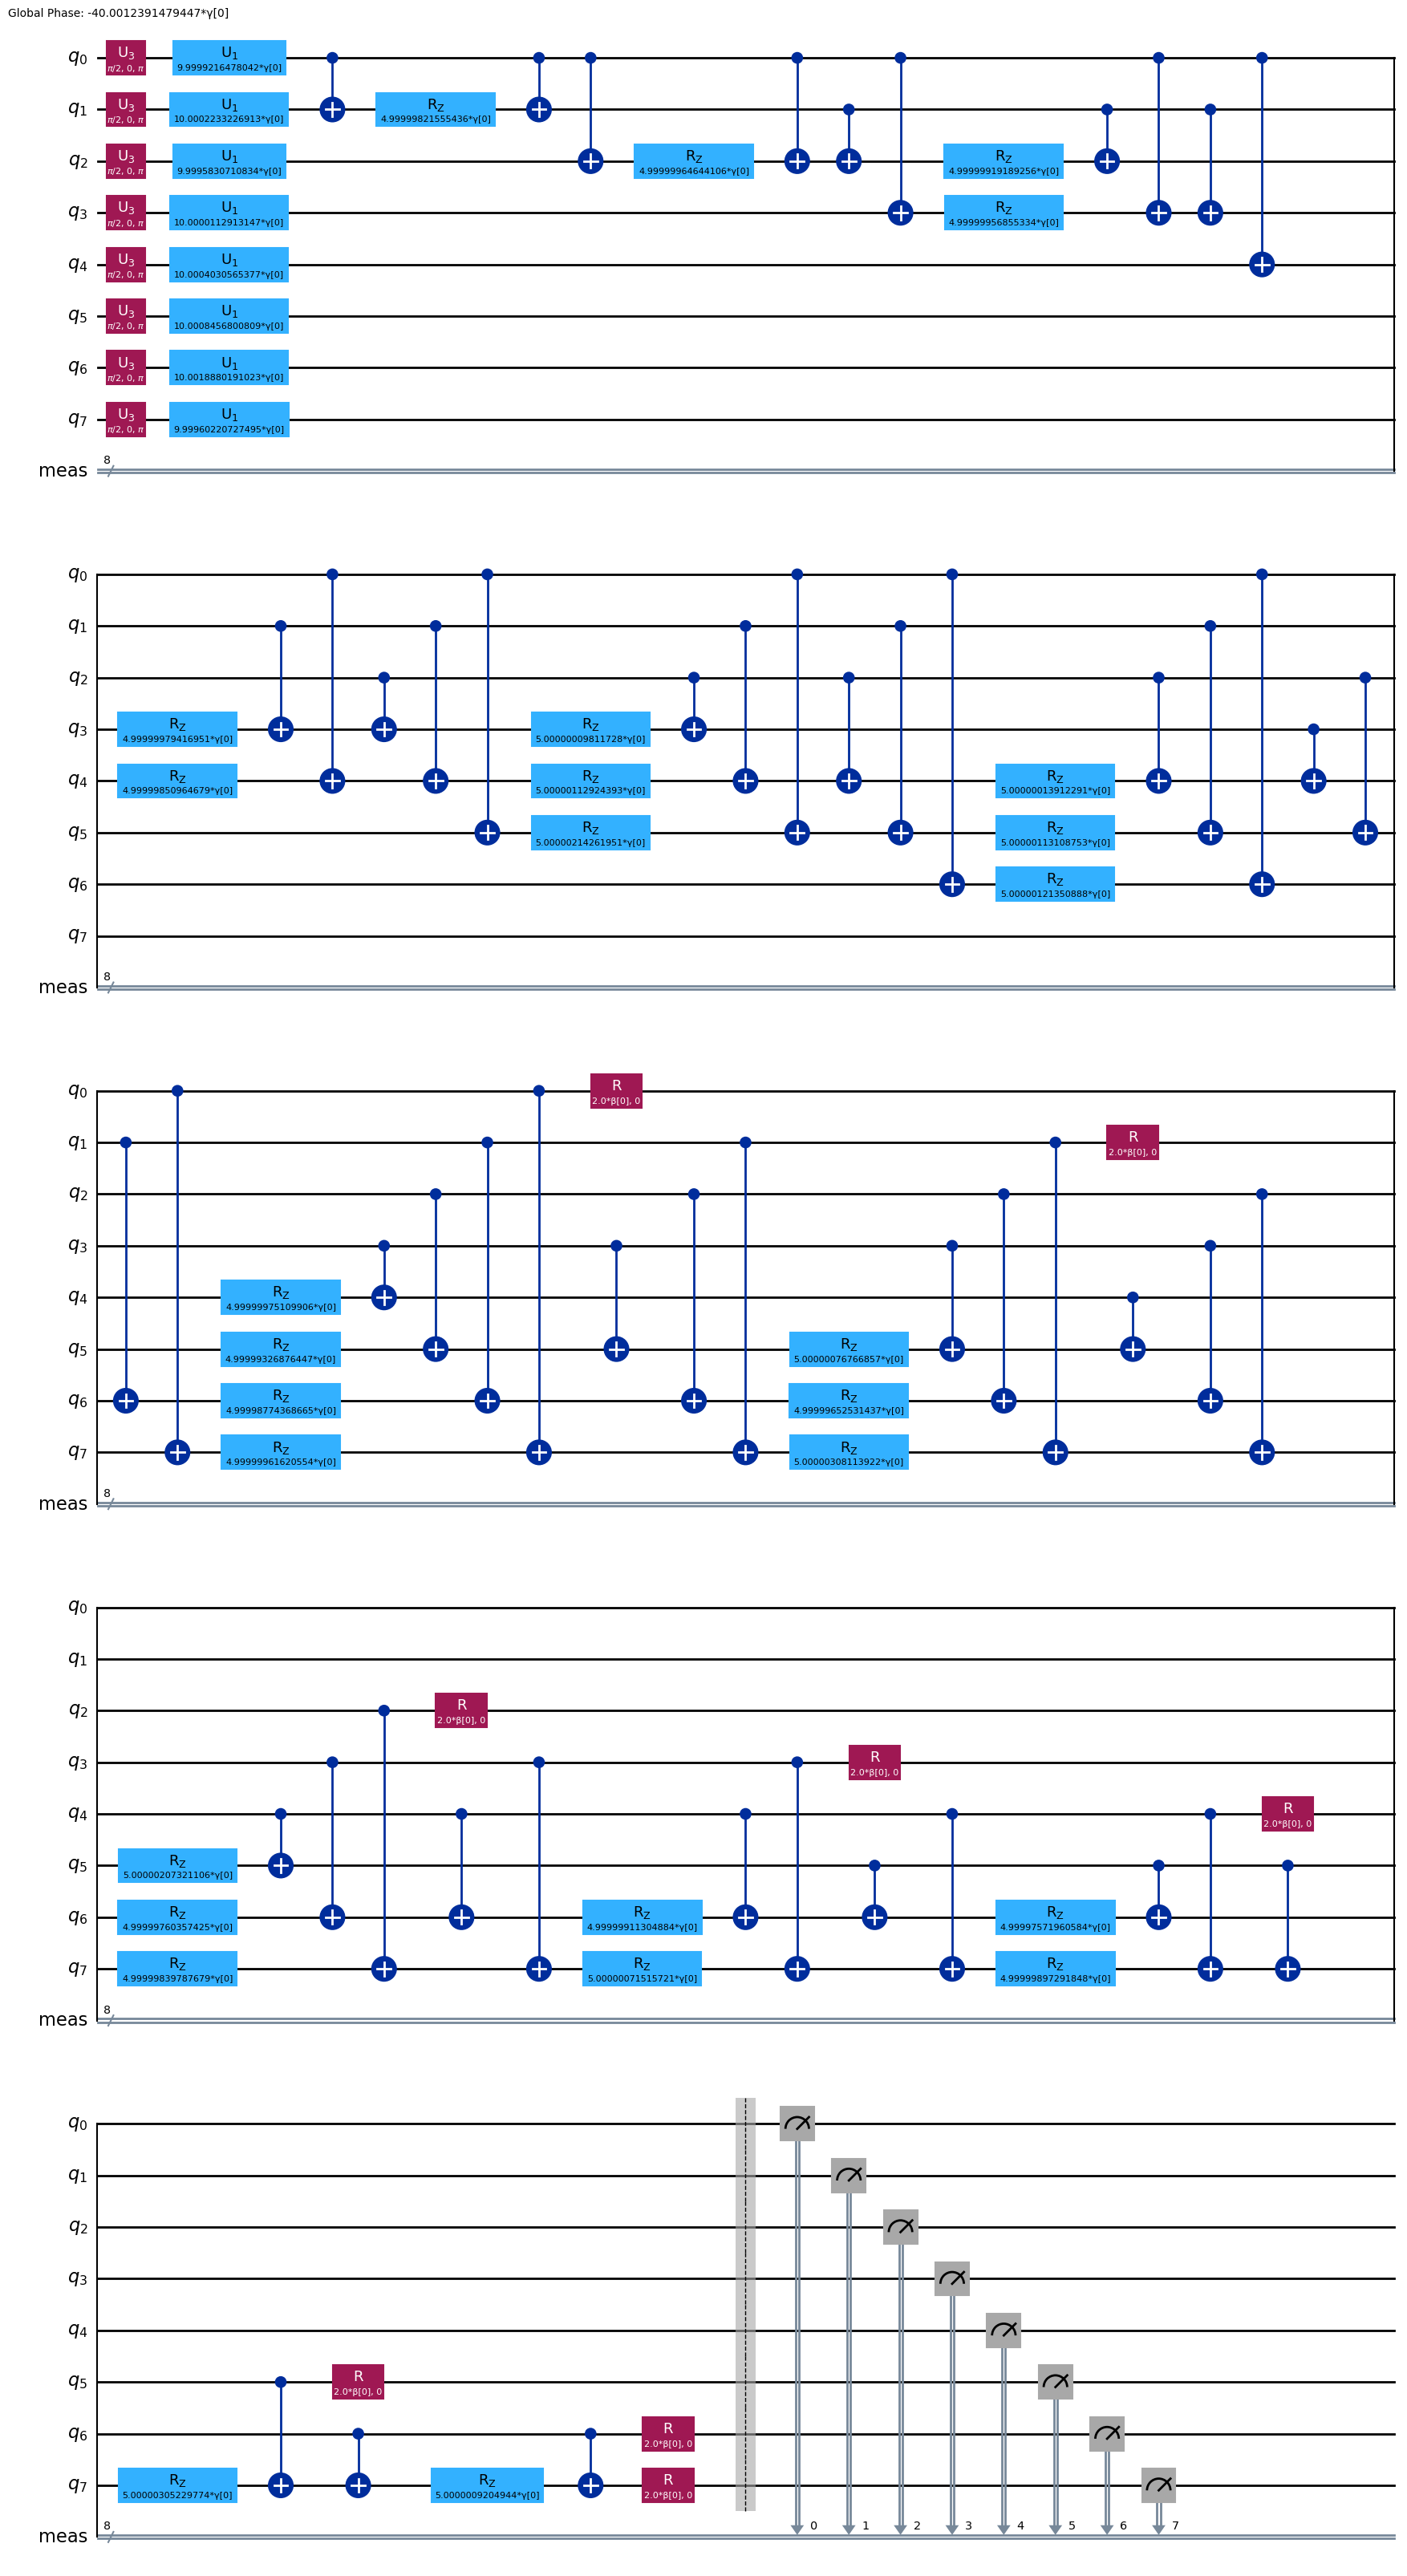

In [ ]:
# QAOA
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa = MinimumEigenOptimizer(qaoa_mes, penalty)
result = qaoa.solve(qp)

decomposed_circuit = qaoa_mes.ansatz.decompose().decompose()
print_result(result, po)
decomposed_circuit.draw("mpl")  # Print the circuit

### QAOA with noise (noisy)
The fourth algorithm that was implemented is QAOA with noise (noisy). In this case, to obtain a noisy simulation, an approach similar to that used for VQE was adopted with a small precaution.

Since the circuit is generated in an optimized way with the solve() method, the problem was first solved without noise, then the generated circuit was extracted and remapped onto the noisy simulator.

Optimal: selection [0. 1. 0. 1. 1. 1. 1. 0.], value -0.0034

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 0 1 0 1]	-0.0006		0.0127
[0 1 1 0 0 0 1 1]	-0.0013		0.0098
[0 0 0 0 1 1 1 0]	-0.0031		0.0098
[1 0 0 1 0 0 1 0]	-0.0018		0.0088
[1 0 0 1 0 1 0 1]	-0.0003		0.0088
[1 1 0 1 0 0 0 0]	-0.0001		0.0078
[1 1 1 1 1 0 0 0]	-0.0001		0.0078
[0 1 0 1 1 1 0 0]	-0.0014		0.0078
[0 0 0 0 0 1 1 0]	-0.0027		0.0078
[0 0 1 0 1 0 0 0]	0.0000		0.0078
[0 1 1 1 1 1 0 0]	-0.0010		0.0078
[1 1 1 0 0 0 0 0]	0.0003		0.0078
[0 1 0 0 1 1 0 0]	-0.0014		0.0078
[1 0 1 0 1 1 0 0]	-0.0007		0.0078
[1 0 1 0 1 0 0 1]	0.0005		0.0078
[1 0 1 0 0 1 0 1]	0.0001		0.0078
[1 1 0 1 1 1 0 0]	-0.0014		0.0078
[0 0 1 0 1 0 1 0]	-0.0018		0.0068
[0 0 0 1 1 0 0 0]	-0.0004		0.0068
[0 0 1 0 0 0 1 0]	-0.0014		0.0068
[1 1 1 1 0 0 1 0]	-0.0016		0.0068
[1 1 0 1 0 0 1 1]	-0.0016		0.0068
[0 1 1 0 0 0 1 0]	-0.0017		0.0068
[1 0 1 0 0 0 1 1]	-0.0010		0

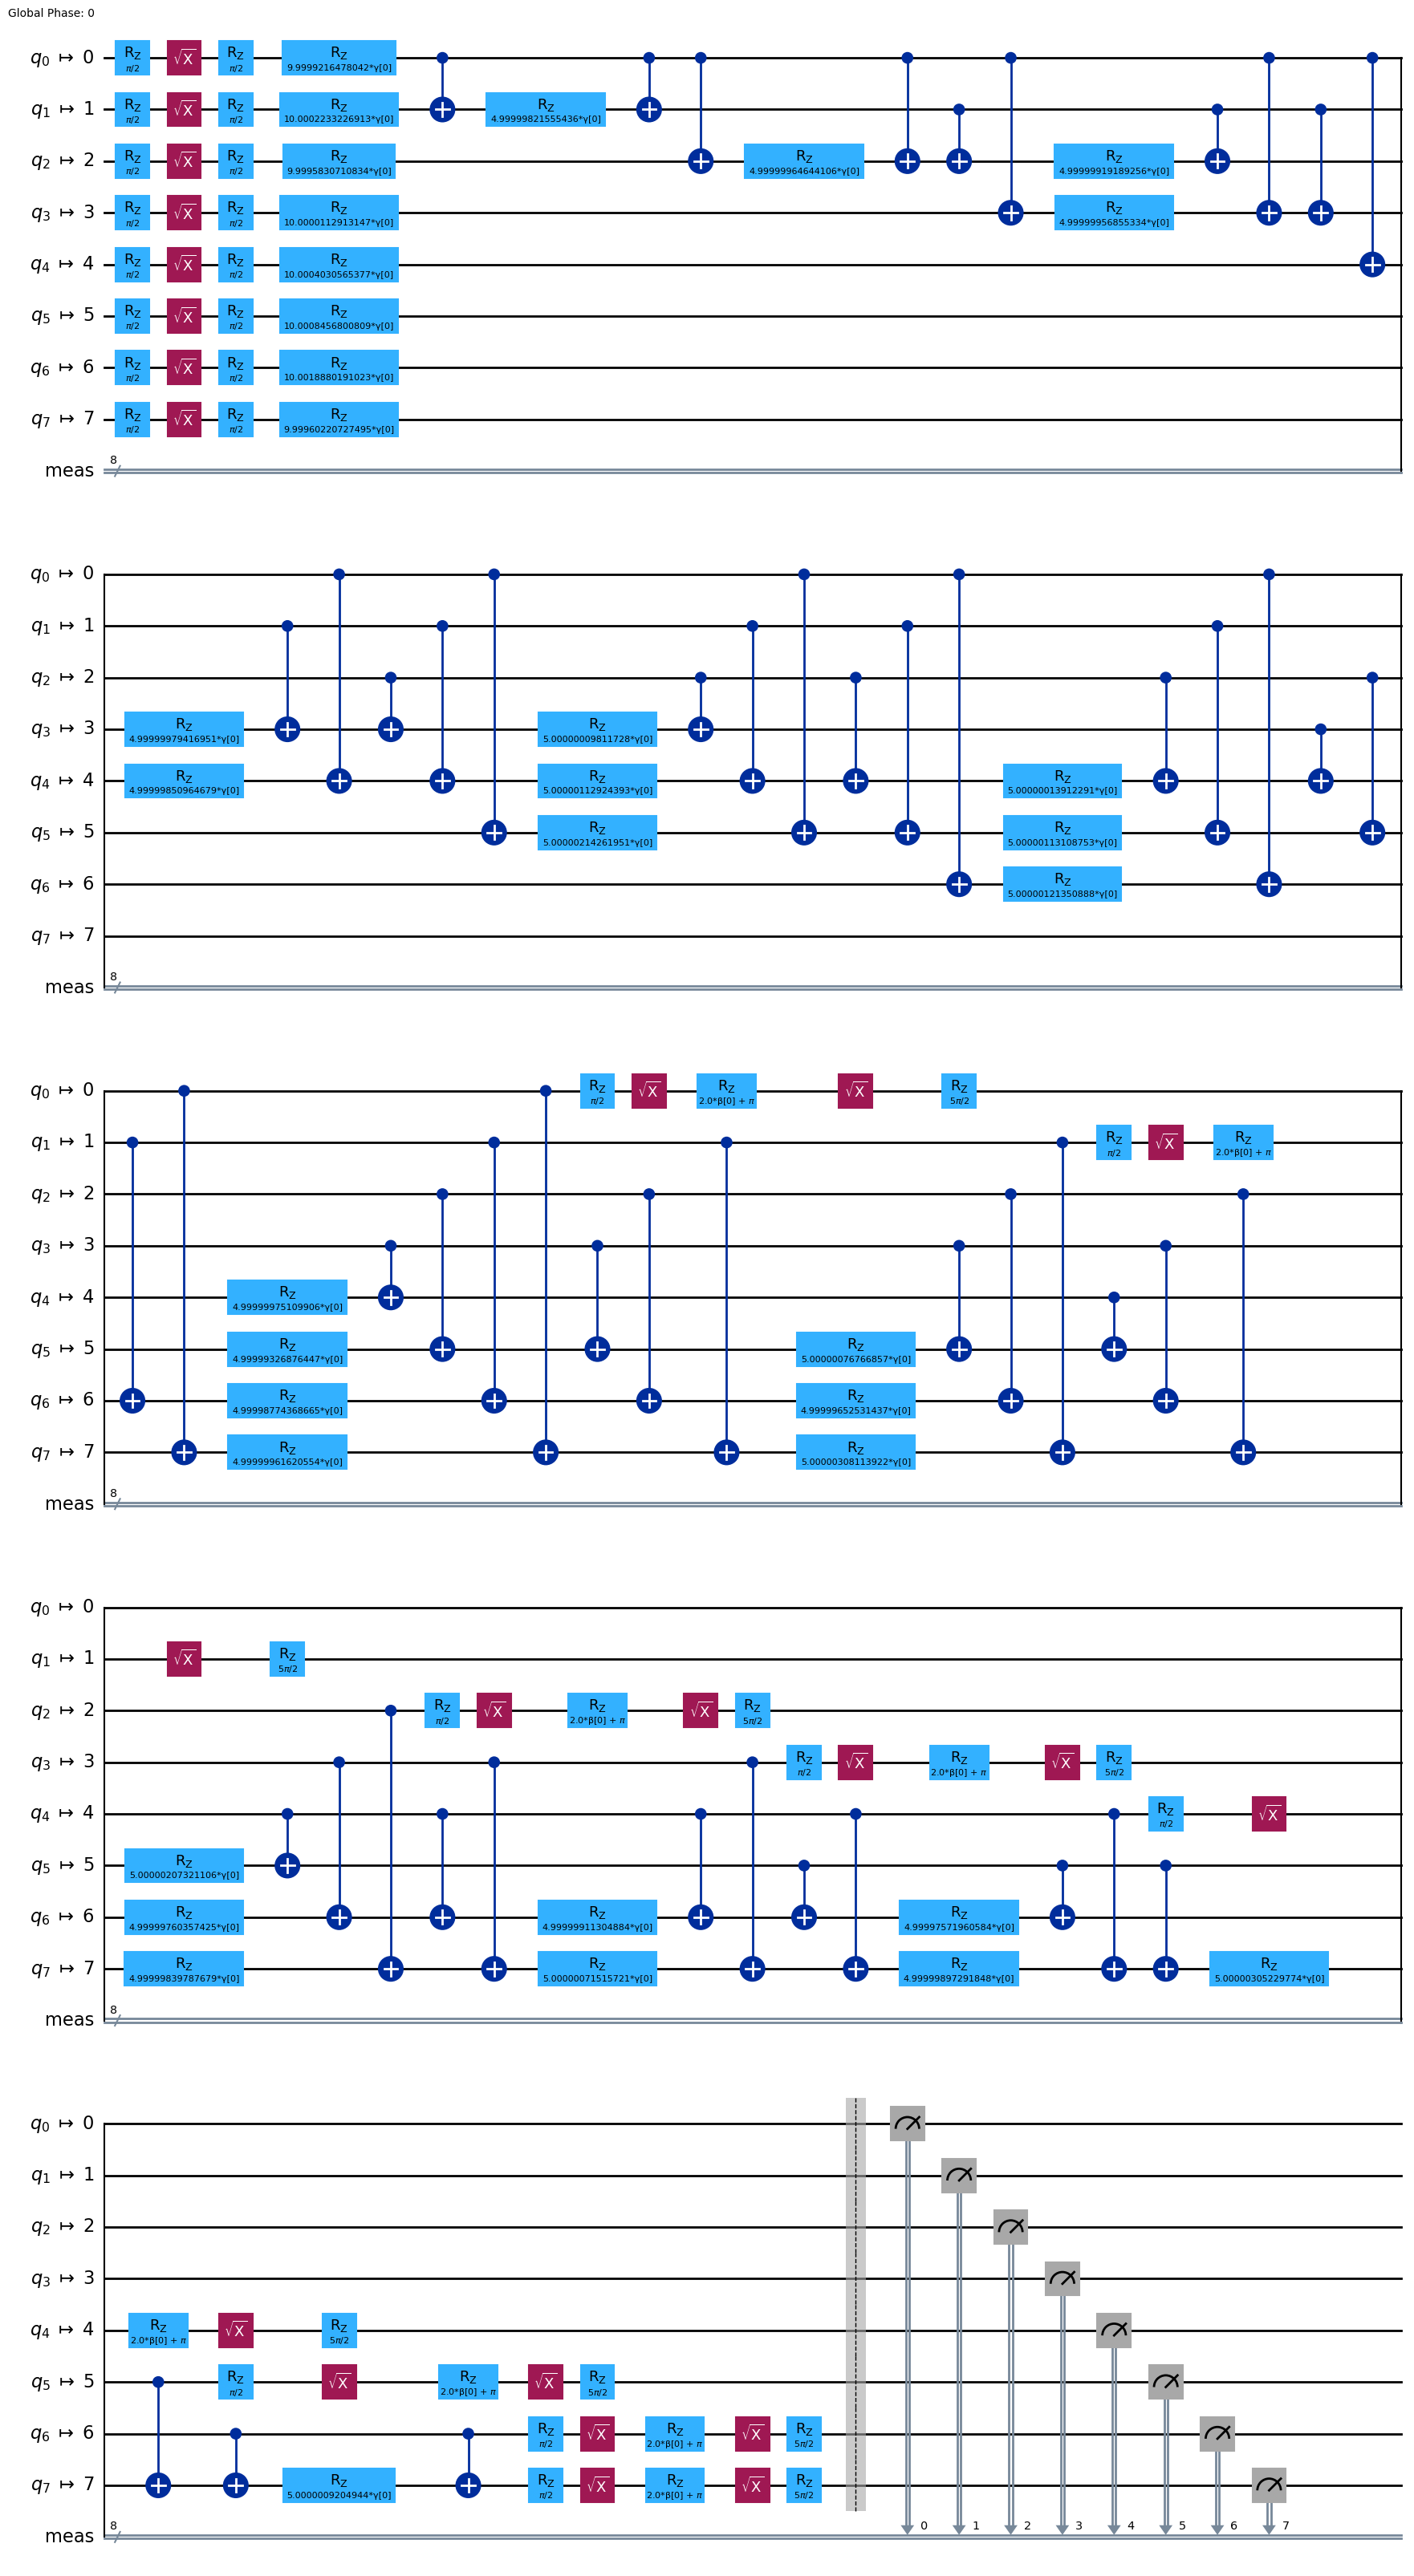

In [ ]:
# QAOA noisy
qaoa_mes_noisy = QAOA(sampler=Sampler(), optimizer=cobyla, reps=1)
qaoa_noisy = MinimumEigenOptimizer(qaoa_mes_noisy, penalty)
_ = qaoa_noisy.solve(qp)

decomposed_circuit_noisy = qaoa_mes_noisy.ansatz.decompose()
transpiled_circuit_noisy = transpile(decomposed_circuit_noisy, backend=simulator)

qaoa_mes_noisy.ansatz = transpiled_circuit_noisy
result_decomposed = qaoa_noisy.solve(qp)

print_result(result_decomposed, po)
transpiled_circuit_noisy.draw("mpl")  # Print the circuit


### QAOA without noise non-optimized (noiseless)

In [ ]:
# Parameter definition
num_assets = assets 
p = 20 * num_assets 

# Create parameters for beta and gamma
beta = Parameter('beta')
gamma = Parameter('gamma')

# Create the circuit for the initial state
qc_i = QuantumCircuit(num_assets)
qc_i.h(range(num_assets))

# Create the mixer circuit
qc_m = QuantumCircuit(num_assets)

# Implementation of the two-body operator (gamma part)
for i in range(num_assets - 1):
    next = (i + 1) % num_assets
    
    # First part of the mixer
    qc_m.ry(-np.pi/2, i)
    qc_m.ry(-np.pi/2, next)
    qc_m.cx(i, next)
    qc_m.rz(-2 * gamma, next)
    qc_m.cx(i, next)
    qc_m.ry(np.pi/2, i)
    qc_m.ry(np.pi/2, next)

# Add barrier for clarity
qc_m.barrier()

# Implementation of the one-body operator (beta part)
qc_m.rx(-np.pi/2, range(num_assets))
qc_m.rz(2*beta, range(num_assets))
qc_m.rx(np.pi/2, range(num_assets))

# Function to create the complete QAOA circuit
def create_qaoa_circuit(num_layers):
    qc_complete = QuantumCircuit(num_assets)
    qc_complete.compose(qc_i, inplace=True)
    
    for _ in range(num_layers):
        qc_complete.compose(qc_m, inplace=True)
    
    qc_complete.measure_all()
    return qc_complete

# Create the circuit with one layer for visualization
qaoa_circuit = create_qaoa_circuit(1)

# ! Uncomment to run
# qaoa_mes = QAOA(sampler=Sampler(), 
#                 optimizer=cobyla, 
#                 reps=p,
#                 initial_state=qc_i,
#                 mixer=qc_m)
# qaoa = MinimumEigenOptimizer(qaoa_mes, penalty)
# qaoa.solve(qp)
# qaoa_circuit.draw("mpl")  # Print the circuit

## Algorithm execution and result processing

To conclude, a good part of the work was dedicated to executing a series of tests to visualize and evaluate the results obtained from the different algorithms.

The tests performed are divided into three groups:
- Algorithms simulated *without* noise.
- Algorithms simulated *with* noise.
- Comparison between algorithms without noise and with noise.

In the first two groups of tests, a series of launches (`n_repeats`) was performed for each algorithm, storing the results to visualize them as follows:
- Three specialized histograms that separately represent the assets selected by the different algorithms.
- A comparative histogram with side-by-side bars that combines the asset selections of the different algorithms.
- A comparative histogram with logarithmic scale that combines the asset selections of the different algorithms.

In the third group of tests, the frequency of selected combinations obtained from noiseless algorithms and noisy algorithms was compared, visualizing them through comparative bar charts.


In [ ]:
selections_qaoa = np.zeros((n_repeats, len(tickers)))
selections_svqe = np.zeros((n_repeats, len(tickers)))
selections_exact_eigensolver = np.zeros((n_repeats, len(tickers)))

selections_qaoa_noisy = np.zeros((n_repeats, len(tickers)))
selections_svqe_noisy = np.zeros((n_repeats, len(tickers)))

all_combinations = list(itertools.product([0, 1], repeat=assets))

combinations_count = {
    'qaoa': {comb: 0 for comb in all_combinations},
    'svqe': {comb: 0 for comb in all_combinations},
    'exact': {comb: 0 for comb in all_combinations}
}

combinations_count_noisy = {
    'qaoa': {comb: 0 for comb in all_combinations},
    'svqe': {comb: 0 for comb in all_combinations},
}

po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=risk_factor, budget=budget)
qp = po.to_quadratic_program()

for i in range(n_repeats):
    # noiseless
    result_qaoa = qaoa.solve(qp)
    selections_qaoa[i] = result_qaoa.x
    selection_qaoa = tuple(result_qaoa.x)

    result_svqe = svqe.solve(qp)
    selections_svqe[i] = result_svqe.x
    selection_svqe = tuple(result_svqe.x)

    result_exact = exact_eigensolver.solve(qp)
    selections_exact_eigensolver[i] = result_exact.x
    selection_exact = tuple(result_exact.x)

    combinations_count['qaoa'][selection_qaoa] += 1
    combinations_count['svqe'][selection_svqe] += 1
    combinations_count['exact'][selection_exact] += 1
    
    # noisy
    result_qaoa = qaoa_noisy.solve(qp)
    selections_qaoa_noisy[i] = result_qaoa.x
    selection_qaoa = tuple(result_qaoa.x)

    result_svqe = svqe_noisy.solve(qp)
    selections_svqe_noisy[i] = result_svqe.x
    selection_svqe = tuple(result_svqe.x)

    combinations_count_noisy['qaoa'][selection_qaoa] += 1
    combinations_count_noisy['svqe'][selection_svqe] += 1

# noiseless
selection_counts_qaoa = np.sum(selections_qaoa, axis=0)
selection_counts_svqe = np.sum(selections_svqe, axis=0)
selection_counts_exact_eigensolver = np.sum(selections_exact_eigensolver, axis=0)

combinations = list(combinations_count['qaoa'].keys())
frequencies_qaoa = list(combinations_count['qaoa'].values())
frequencies_svqe = list(combinations_count['svqe'].values())
frequencies_exact = list(combinations_count['exact'].values())

# Filter combinations with value 0
filtered_combinations = []
filtered_frequencies_qaoa = []
filtered_frequencies_svqe = []
filtered_frequencies_exact = []

for comb, fq, fs, fe in zip(combinations, frequencies_qaoa, frequencies_svqe, frequencies_exact):
    if fq > 0 or fs > 0 or fe > 0:
        filtered_combinations.append(comb)
        filtered_frequencies_qaoa.append(fq)
        filtered_frequencies_svqe.append(fs)
        filtered_frequencies_exact.append(fe)

# noisy
selection_counts_qaoa_noisy = np.sum(selections_qaoa_noisy, axis=0)
selection_counts_svqe_noisy = np.sum(selections_svqe_noisy, axis=0)
combinations_noisy = list(combinations_count_noisy['qaoa'].keys())
frequencies_qaoa_noisy = list(combinations_count_noisy['qaoa'].values())
frequencies_svqe_noisy = list(combinations_count_noisy['svqe'].values())

# Filter combinations with value 0
filtered_combinations_noisy = []
filtered_frequencies_qaoa_noisy = []
filtered_frequencies_svqe_noisy = []
filtered_frequencies_exact_x_noise = []

for comb, fq, fs, fe in zip(combinations_noisy, frequencies_qaoa_noisy, frequencies_svqe_noisy, frequencies_exact):
    if fq > 0 or fs > 0:
        filtered_combinations_noisy.append(comb)
        filtered_frequencies_qaoa_noisy.append(fq)
        filtered_frequencies_svqe_noisy.append(fs)
        filtered_frequencies_exact_x_noise.append(fe)
        
# noiseless vs noisy
filtered_combinations_vs = list(set(filtered_combinations_noisy) | set(filtered_combinations))
filtered_frequencies_qaoa_vs = list(set(filtered_frequencies_qaoa_noisy) | set(filtered_frequencies_qaoa))
filtered_frequencies_svqe_vs = list(set(filtered_frequencies_svqe_noisy) | set(filtered_frequencies_svqe))

### Color definition for graphs

In [ ]:
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Paired")
svqe_noiseless_color = palette[1]
qaoa_noiseless_color = palette[3]
exact_color = palette[5]
svqe_noisy_color = palette[0]
qaoa_noisy_color = palette[2]

qaoa_color = "blue"
svqe_color = "green"
exact_color = "red"

### Results without noise (noiseless)

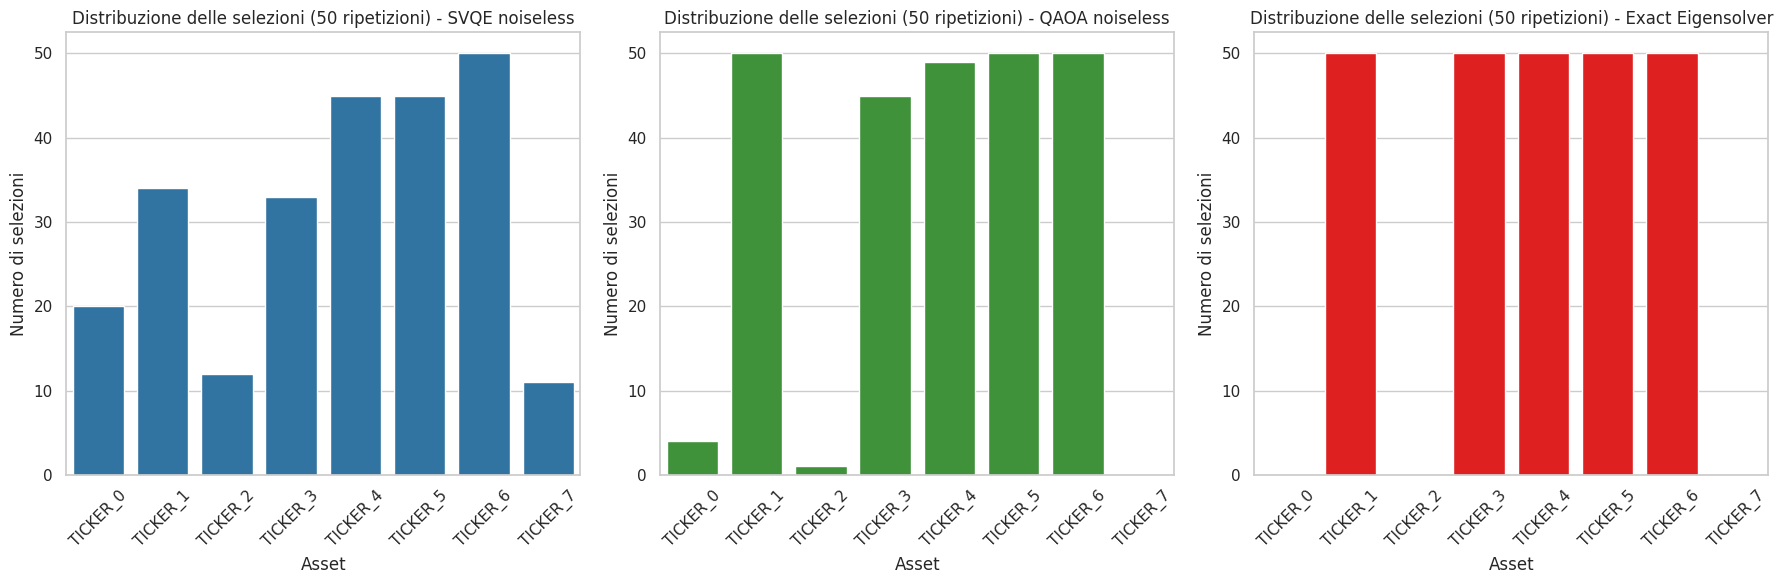

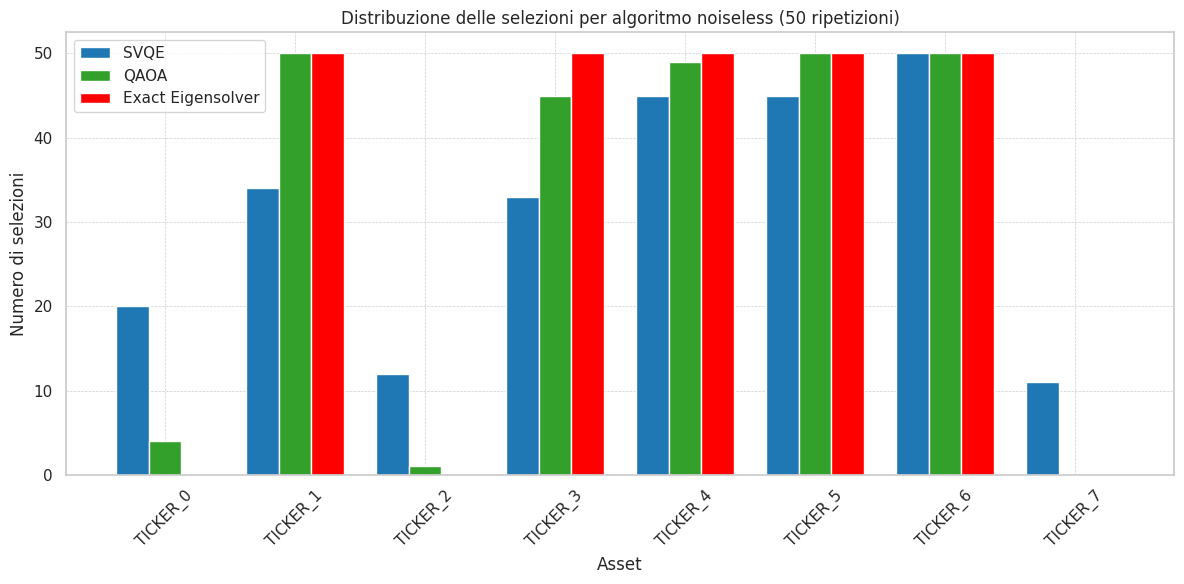

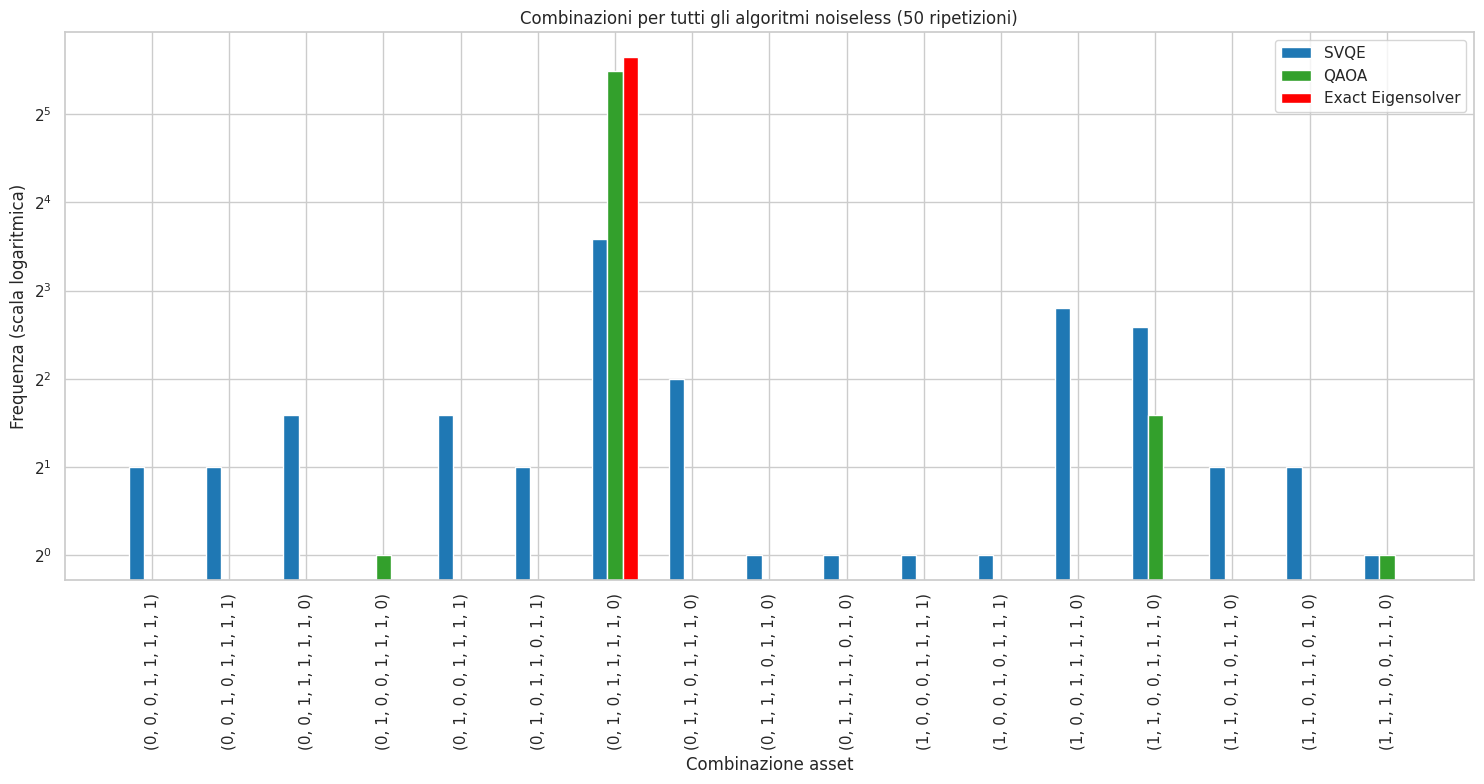

In [ ]:
## Noiseless
def plot_noiseless():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # SVQE noiseless
    sns.barplot(x=tickers, y=selection_counts_svqe, ax=axs[0], color=svqe_noiseless_color)
    axs[0].set_title(f"Selection Distribution ({n_repeats} repetitions) - SVQE noiseless")
    axs[0].set_xlabel("Asset")
    axs[0].set_ylabel("Number of selections")
    axs[0].tick_params(axis='x', rotation=45)
    
    # QAOA noiseless
    sns.barplot(x=tickers, y=selection_counts_qaoa, ax=axs[1], color=qaoa_noiseless_color)
    axs[1].set_title(f"Selection Distribution ({n_repeats} repetitions) - QAOA noiseless")
    axs[1].set_xlabel("Asset")
    axs[1].set_ylabel("Number of selections")
    axs[1].tick_params(axis='x', rotation=45)

    # Exact Eigensolver
    sns.barplot(x=tickers, y=selection_counts_exact_eigensolver, ax=axs[2], color=exact_color)
    axs[2].set_title(f"Selection Distribution ({n_repeats} repetitions) - Exact Eigensolver")
    axs[2].set_xlabel("Asset")
    axs[2].set_ylabel("Number of selections")
    axs[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Aggregated plot of noiseless selections
def plot_aggregate():
    width = 0.25
    x = np.arange(len(tickers))

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, selection_counts_svqe, width, color=svqe_noiseless_color, label='SVQE')
    plt.bar(x, selection_counts_qaoa, width, color=qaoa_noiseless_color, label='QAOA')
    plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

    plt.title(f"Selection Distribution per Noiseless Algorithm ({n_repeats} repetitions)")
    plt.xlabel('Asset')
    plt.ylabel('Number of selections')
    plt.xticks(x, tickers, rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Noiseless combinations plot
def plot_combinations():
    n_combinations = len(filtered_combinations)
    index = np.arange(n_combinations)
    width = 0.2  # Bar width

    plt.figure(figsize=(15, 8))

    # Bars for SVQE
    plt.bar(index - width, filtered_frequencies_svqe, width, color=svqe_noiseless_color, label='SVQE')
    # Bars for QAOA
    plt.bar(index, filtered_frequencies_qaoa, width, color=qaoa_noiseless_color, label='QAOA')
    # Bars for Exact Eigensolver
    plt.bar(index + width, filtered_frequencies_exact, width, color=exact_color, label='Exact Eigensolver')

    plt.yscale('log', base=2)
    plt.title(f"Combinations for All Noiseless Algorithms ({n_repeats} repetitions)")
    plt.xlabel("Asset Combination")
    plt.ylabel("Frequency (logarithmic scale)")
    plt.xticks(index, [str(comb) for comb in filtered_combinations], rotation=90)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the functions
plot_noiseless()
plot_aggregate()
plot_combinations()

### Results with noise (noisy)

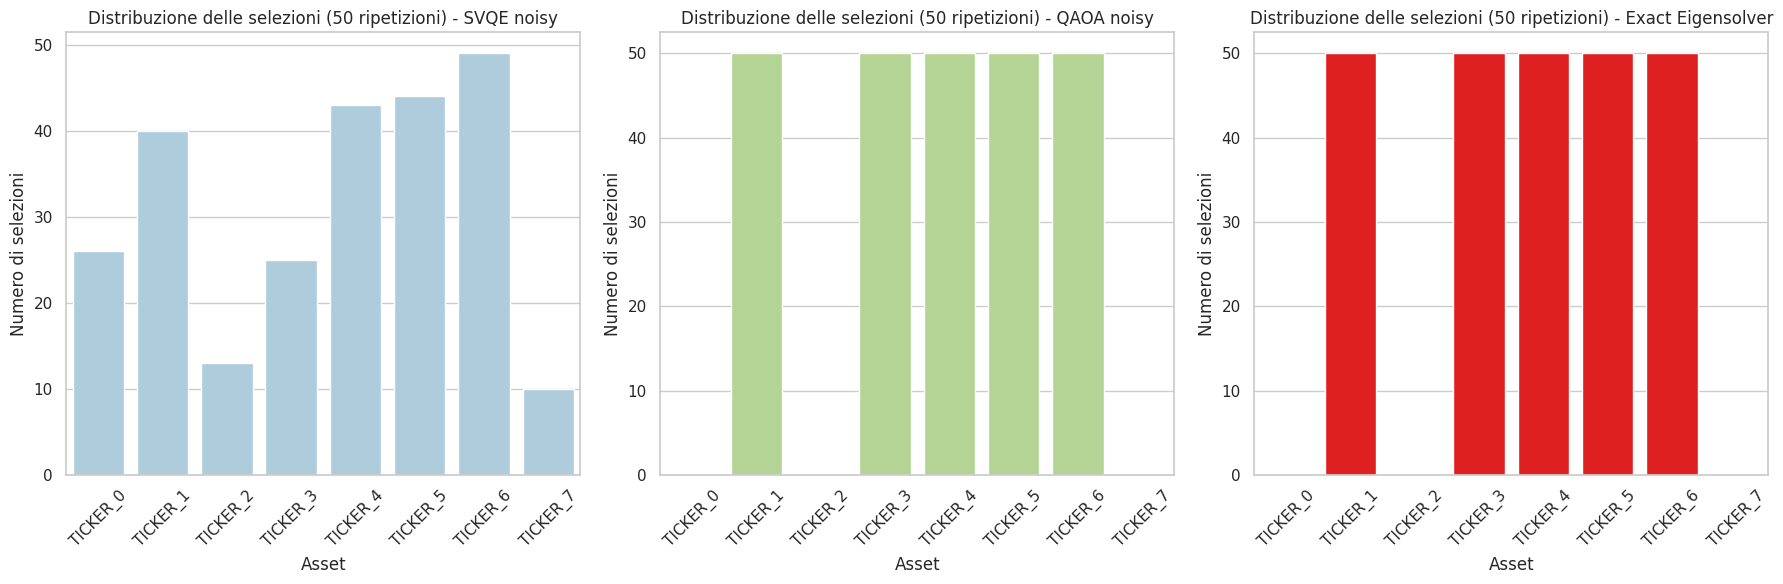

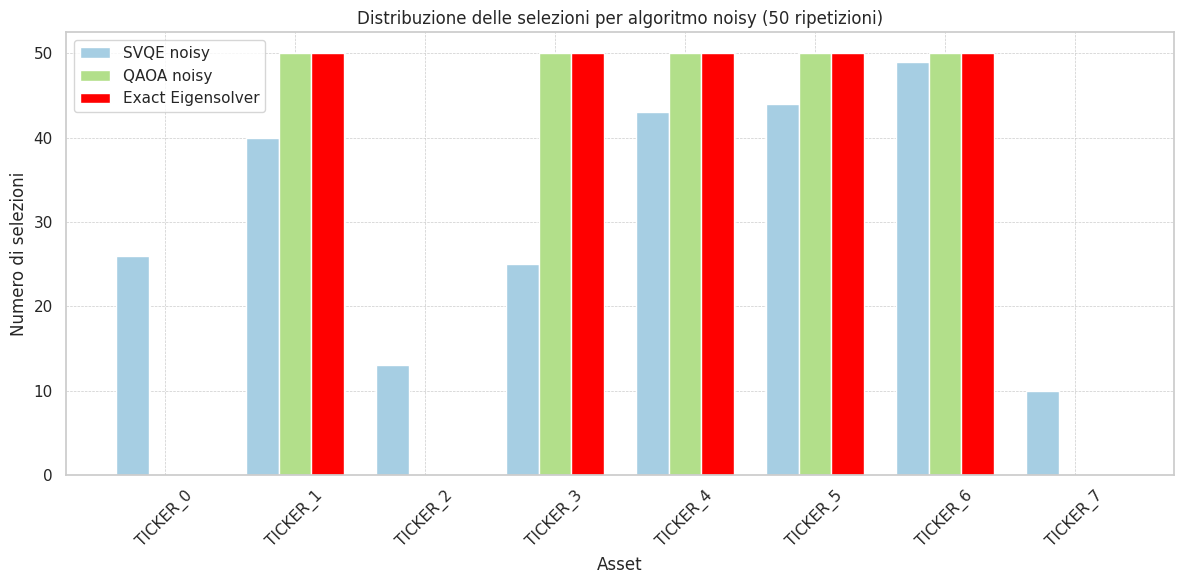

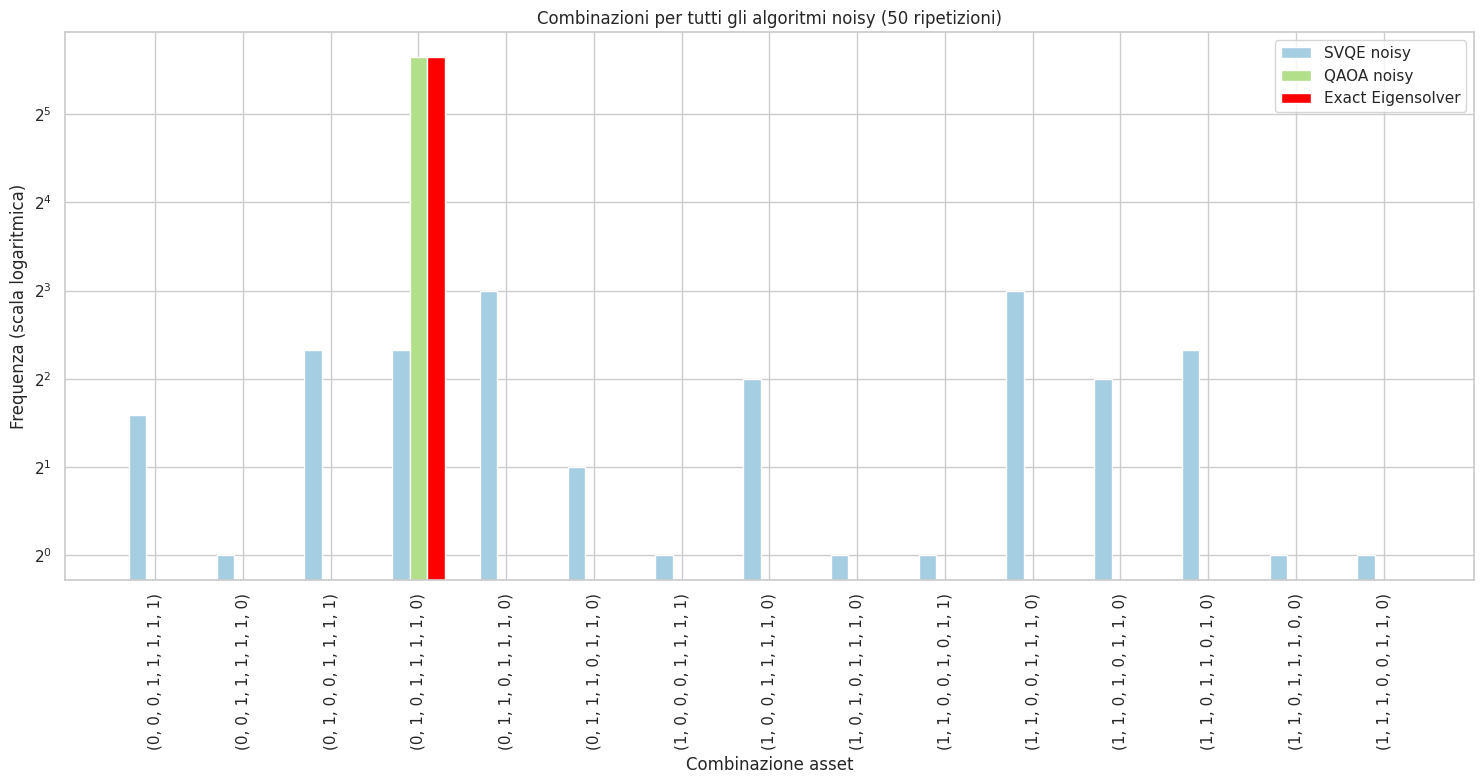

In [ ]:
## Noisy
def plot_noisy():
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # SVQE noisy
    sns.barplot(x=tickers, y=selection_counts_svqe_noisy, ax=axs[0], color=svqe_noisy_color)
    axs[0].set_title(f"Selection Distribution ({n_repeats} repetitions) - SVQE noisy")
    axs[0].set_xlabel("Asset")
    axs[0].set_ylabel("Number of selections")
    axs[0].tick_params(axis='x', rotation=45)
    
    # QAOA noisy
    sns.barplot(x=tickers, y=selection_counts_qaoa_noisy, ax=axs[1], color=qaoa_noisy_color)
    axs[1].set_title(f"Selection Distribution ({n_repeats} repetitions) - QAOA noisy")
    axs[1].set_xlabel("Asset")
    axs[1].set_ylabel("Number of selections")
    axs[1].tick_params(axis='x', rotation=45)

    # Exact Eigensolver
    sns.barplot(x=tickers, y=selection_counts_exact_eigensolver, ax=axs[2], color=exact_color)
    axs[2].set_title(f"Selection Distribution ({n_repeats} repetitions) - Exact Eigensolver")
    axs[2].set_xlabel("Asset")
    axs[2].set_ylabel("Number of selections")
    axs[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Aggregated plot of noisy selections
def plot_aggregate_noisy():
    width = 0.25
    x = np.arange(len(tickers))

    plt.figure(figsize=(12, 6))
    plt.bar(x - width, selection_counts_svqe_noisy, width, color=svqe_noisy_color, label='SVQE noisy')
    plt.bar(x, selection_counts_qaoa_noisy, width, color=qaoa_noisy_color, label='QAOA noisy')
    plt.bar(x + width, selection_counts_exact_eigensolver, width, color=exact_color, label='Exact Eigensolver')

    plt.title(f"Selection Distribution per Noisy Algorithm ({n_repeats} repetitions)")
    plt.xlabel('Asset')
    plt.ylabel('Number of selections')
    plt.xticks(x, tickers, rotation=45)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Noisy combinations plot
def plot_combinations_noisy():
    n_combinations_noisy = len(filtered_combinations_noisy)
    index = np.arange(n_combinations_noisy)
    width = 0.2  # Bar width

    plt.figure(figsize=(15, 8))

    # Bars for SVQE
    plt.bar(index - width, filtered_frequencies_svqe_noisy, width, color=svqe_noisy_color, label='SVQE noisy')
    # Bars for QAOA
    plt.bar(index, filtered_frequencies_qaoa_noisy, width, color=qaoa_noisy_color, label='QAOA noisy')
    # Bars for Exact Eigensolver
    plt.bar(index + width, filtered_frequencies_exact_x_noise, width, color=exact_color, label='Exact Eigensolver')

    plt.yscale('log', base=2)
    plt.title(f"Combinations for All Noisy Algorithms ({n_repeats} repetitions)")
    plt.xlabel("Asset Combination")
    plt.ylabel("Frequency (logarithmic scale)")
    plt.xticks(index, [str(comb) for comb in filtered_combinations_noisy], rotation=90)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the functions
plot_noisy()
plot_aggregate_noisy()
plot_combinations_noisy()


### Algorithm comparison (noiseless vs noisy)

In [ ]:
# Extract combinations of interest
all_combinations_vs = list(set(filtered_combinations_noisy).union(set(filtered_combinations)))

filtered_vqe_vs = []
filtered_vqe_noisy_vs = []
filtered_qaoa_vs = []
filtered_qaoa_noisy_vs = []

filtered_combinations_vqe_vs = []
filtered_combinations_qaoa_vs = []
filtered_frequencies_vqe_vs = []
filtered_frequencies_vqe_noisy_vs = []
filtered_frequencies_qaoa_vs = []
filtered_frequencies_qaoa_noisy_vs = []

# Filter combinations without solutions
for comb in all_combinations_vs:
    fq_vqe = filtered_frequencies_svqe[filtered_combinations.index(comb)] if comb in filtered_combinations else 0
    fq_qaoa = filtered_frequencies_qaoa[filtered_combinations.index(comb)] if comb in filtered_combinations else 0
    fq_vqe_noisy = filtered_frequencies_svqe_noisy[filtered_combinations_noisy.index(comb)] if comb in filtered_combinations_noisy else 0
    fq_qaoa_noisy = filtered_frequencies_qaoa_noisy[filtered_combinations_noisy.index(comb)] if comb in filtered_combinations_noisy else 0

    if fq_vqe > 0 or fq_vqe_noisy > 0:
        filtered_combinations_vqe_vs.append(comb)
        filtered_frequencies_vqe_vs.append(fq_vqe)
        filtered_frequencies_vqe_noisy_vs.append(fq_vqe_noisy)
    
    if fq_qaoa > 0 or fq_qaoa_noisy > 0:
        filtered_combinations_qaoa_vs.append(comb)
        filtered_frequencies_qaoa_vs.append(fq_qaoa)
        filtered_frequencies_qaoa_noisy_vs.append(fq_qaoa_noisy)

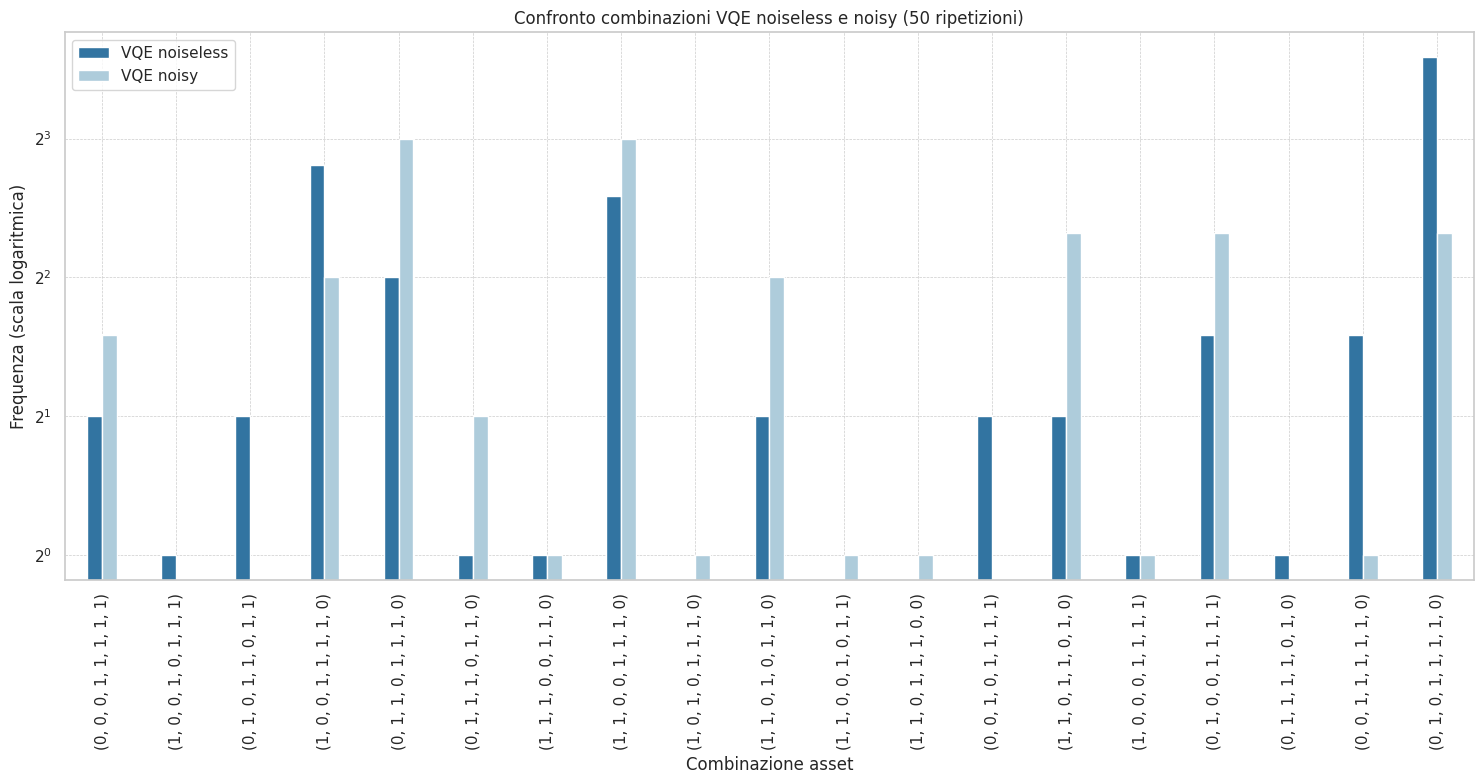

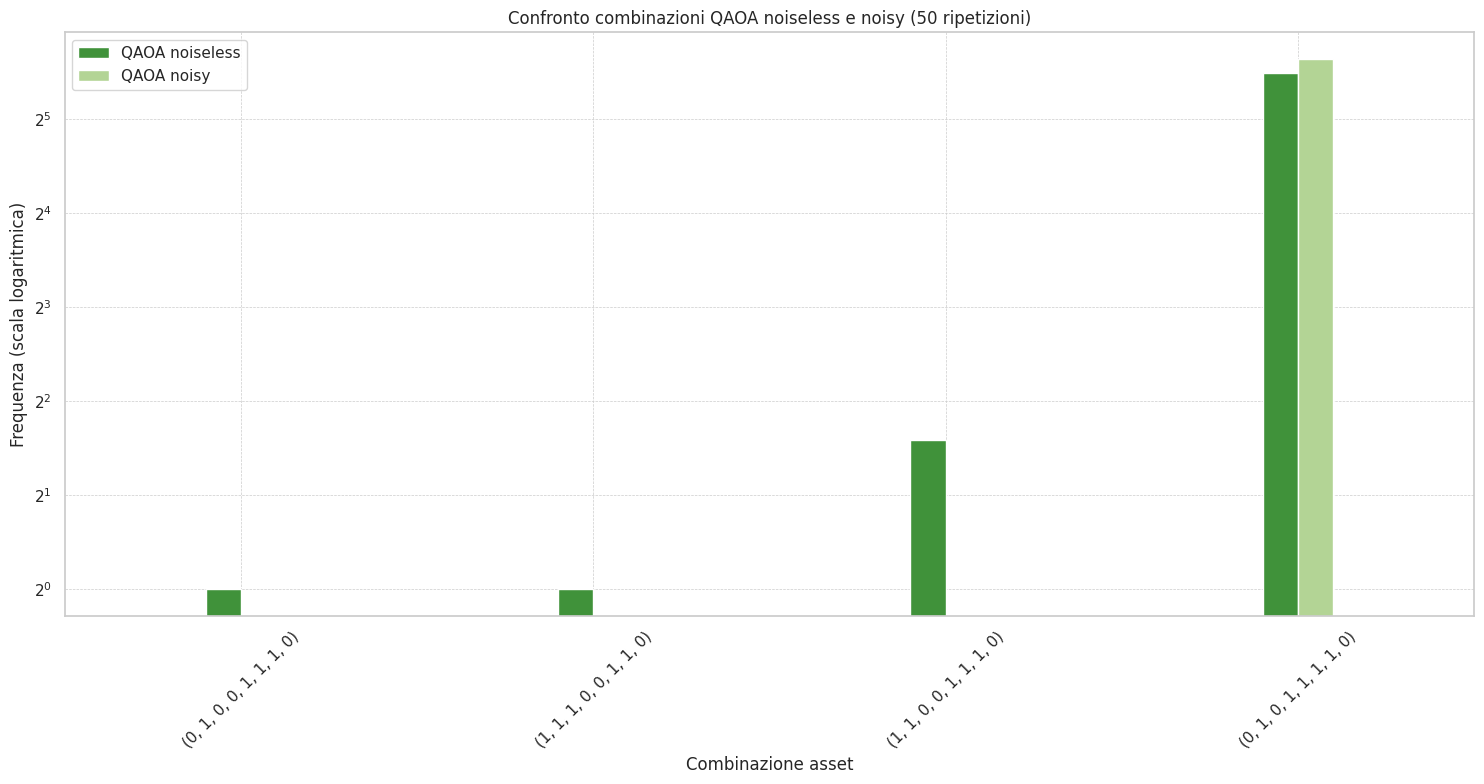

In [ ]:
# SVQE combinations plot
width = 0.2  # Bar width

n_combinations_vs = len(filtered_combinations_vqe_vs)
index = np.arange(n_combinations_vs)
data_vqe = {
    "Combination": [str(comb) for comb in filtered_combinations_vqe_vs] * 2,
    "Frequency": filtered_frequencies_vqe_vs + filtered_frequencies_vqe_noisy_vs,
    "Type": ["VQE noiseless"] * n_combinations_vs + ["VQE noisy"] * n_combinations_vs
}

plt.figure(figsize=(15, 8))
sns.barplot(
    data=data_vqe,
    x="Combination",
    y="Frequency",
    hue="Type",
    palette={"VQE noiseless": svqe_noiseless_color, "VQE noisy": svqe_noisy_color},
    dodge=True,
    width=width * 2 
)
plt.yscale('log', base=2)
plt.title(f"VQE Noiseless vs Noisy Combinations Comparison ({n_repeats} repetitions)")
plt.xlabel("Asset Combination")
plt.ylabel("Frequency (logarithmic scale)")
plt.xticks(rotation=90)
plt.legend(title="")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# QAOA combinations plot
n_combinations_vs = len(filtered_combinations_qaoa_vs)
data_qaoa = {
    "Combination": [str(comb) for comb in filtered_combinations_qaoa_vs] * 2,
    "Frequency": filtered_frequencies_qaoa_vs + filtered_frequencies_qaoa_noisy_vs,
    "Type": ["QAOA noiseless"] * n_combinations_vs + ["QAOA noisy"] * n_combinations_vs
}

plt.figure(figsize=(15, 8))
sns.barplot(
    data=data_qaoa,
    x="Combination",
    y="Frequency",
    hue="Type",
    palette={"QAOA noiseless": qaoa_noiseless_color, "QAOA noisy": qaoa_noisy_color},
    dodge=True,
    width=width
)
plt.yscale('log', base=2)
plt.title(f"QAOA Noiseless vs Noisy Combinations Comparison ({n_repeats} repetitions)")
plt.xlabel("Asset Combination")
plt.ylabel("Frequency (logarithmic scale)")
plt.xticks(rotation=45)
plt.legend(title="")
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


### Risk vs expected return analysis for different algorithms

In this cell, we perform the following steps:

1. We define a series of risk values (`risks`) using `np.linspace` to generate 20 evenly spaced values between 0 and 1.
2. We calculate the optimal values for each risk value using the three portfolio optimization algorithms (`QAOA`, `SVQE`, `Exact Eigensolver`):
   - **QAOA**:
     - We initialize an empty list (`values_per_risk_qaoa`) to store the optimal values.
     - For each risk value, we create an instance of `PortfolioOptimization` with the appropriate parameters and convert the problem into a quadratic program (`qp`).
     - We solve the problem using `qaoa` and store the optimal value (`result.fval`) in the list.
   - **SVQE**:
     - We initialize an empty list (`values_per_risk_svqe`) to store the optimal values.
     - For each risk value, we create an instance of `PortfolioOptimization` with the appropriate parameters and convert the problem into a quadratic program (`qp`).
     - We solve the problem using `svqe` and store the optimal value (`result.fval`) in the list.
   - **Exact Eigensolver**:
     - We initialize an empty list (`values_exact_eigensolver`) to store the optimal values.
     - For each risk value, we create an instance of `PortfolioOptimization` with the appropriate parameters and convert the problem into a quadratic program (`qp`).
     - We solve the problem using `exact_eigensolver` and store the optimal value (`result.fval`) in the list.
3. We create a graph to visualize the relationship between the risk factor and the optimal value for each algorithm:
   - We use `plt.plot` to trace the optimal values as a function of the risk factor for `QAOA`, `SVQE`, and `Exact Eigensolver`, with different markers and colors for each algorithm.
   - We set the graph title to "Risk vs expected return for different algorithms".
   - We label the x and y axes as "Risk factor" and "Optimal value" respectively.
   - We add a grid and legend to improve graph readability.
   - We use `plt.tight_layout` to optimize the graph layout and `plt.show` to display it.

In [ ]:
risks = np.linspace(0, 1, 20)

# Results for QAOA
values_per_risk_qaoa = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = qaoa.solve(qp)
    values_per_risk_qaoa.append(result.fval)

# Results for SVQE
values_per_risk_svqe = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = svqe.solve(qp)
    values_per_risk_svqe.append(result.fval)

# Results for Exact Eigensolver
values_exact_eigensolver = []
for r in risks:
    po = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=r, budget=budget)
    qp = po.to_quadratic_program()
    result = exact_eigensolver.solve(qp)
    values_exact_eigensolver.append(result.fval)

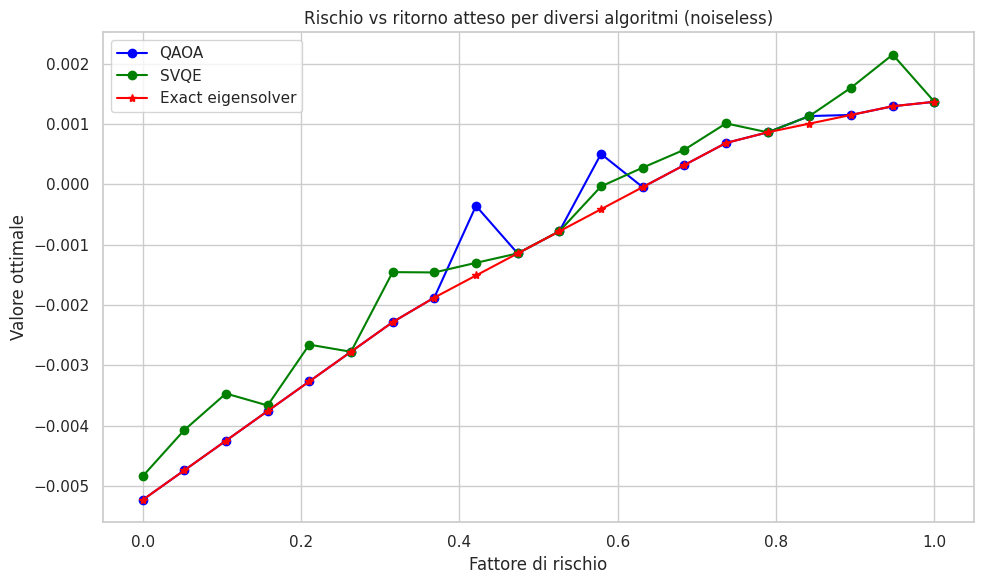

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot for QAOA
plt.plot(risks, values_per_risk_qaoa, marker='o', linestyle='-', color=qaoa_color, label='QAOA')

# Plot for SVQE
plt.plot(risks, values_per_risk_svqe, marker='o', linestyle='-', color=svqe_color, label='SVQE')

# Plot for Exact Eigensolver
plt.plot(risks, values_exact_eigensolver, marker='*', linestyle='-', color=exact_color, label='Exact eigensolver')

plt.title("Risk vs Expected Return for Different Algorithms (noiseless)")
plt.xlabel("Risk Factor")
plt.ylabel("Optimal Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()